## Sample Analysis

In [2]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

# with open('/srv/scratch/z5297792/Sample/sample_data.pkl', 'rb') as file:
#     sample_data1 = pickle.load(file)
# print(sample_data1.keys())

# with open('/srv/scratch/z5297792/Sample/500plus_sample_data.pkl', 'rb') as file:
#     sample_data2 = pickle.load(file)
# print(sample_data2.keys())

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())
print(the_frontier_eddies)


['Eddy790', 'Eddy110', 'Eddy134', 'Eddy775']


In [3]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from matplotlib.patches import Ellipse
from scipy.interpolate import interp1d


fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

eddy = 'Eddy22' # AE no-tilt # good \
eddy = 'Eddy110' # AE tilt # good off my own analysis \
eddy = 'Eddy134' # CE non-tilt # best \
eddy = 'Eddy133' # CE tilt \
\
eddy = 'Eddy790' # AE non-tilt # best \
eddy = 'Eddy761' # CE non-tilt # not bad \
eddy = 'Eddy749' # CE tilt # good \
eddy = 'Eddy775' # CE tilt # best \
\
The Sample Frontiers: \
\
AE790 no-tilt \
AE110 tilt \
CE134 no-tilt \
CE775 tilt 




## The Frontiers

In [4]:
# cap everything at COWs depth
d_dic = {}
for eddy in the_frontier_eddies:
    d_df = pd.DataFrame()
    for t in range(30):
        df = frontier_sample_data[eddy]['T'+str(t)]['COW']['x']
        d_df['T'+str(t)] = [df.isna().idxmax() if df.isna().any() else len(df)]
    d_dic[eddy] = d_df


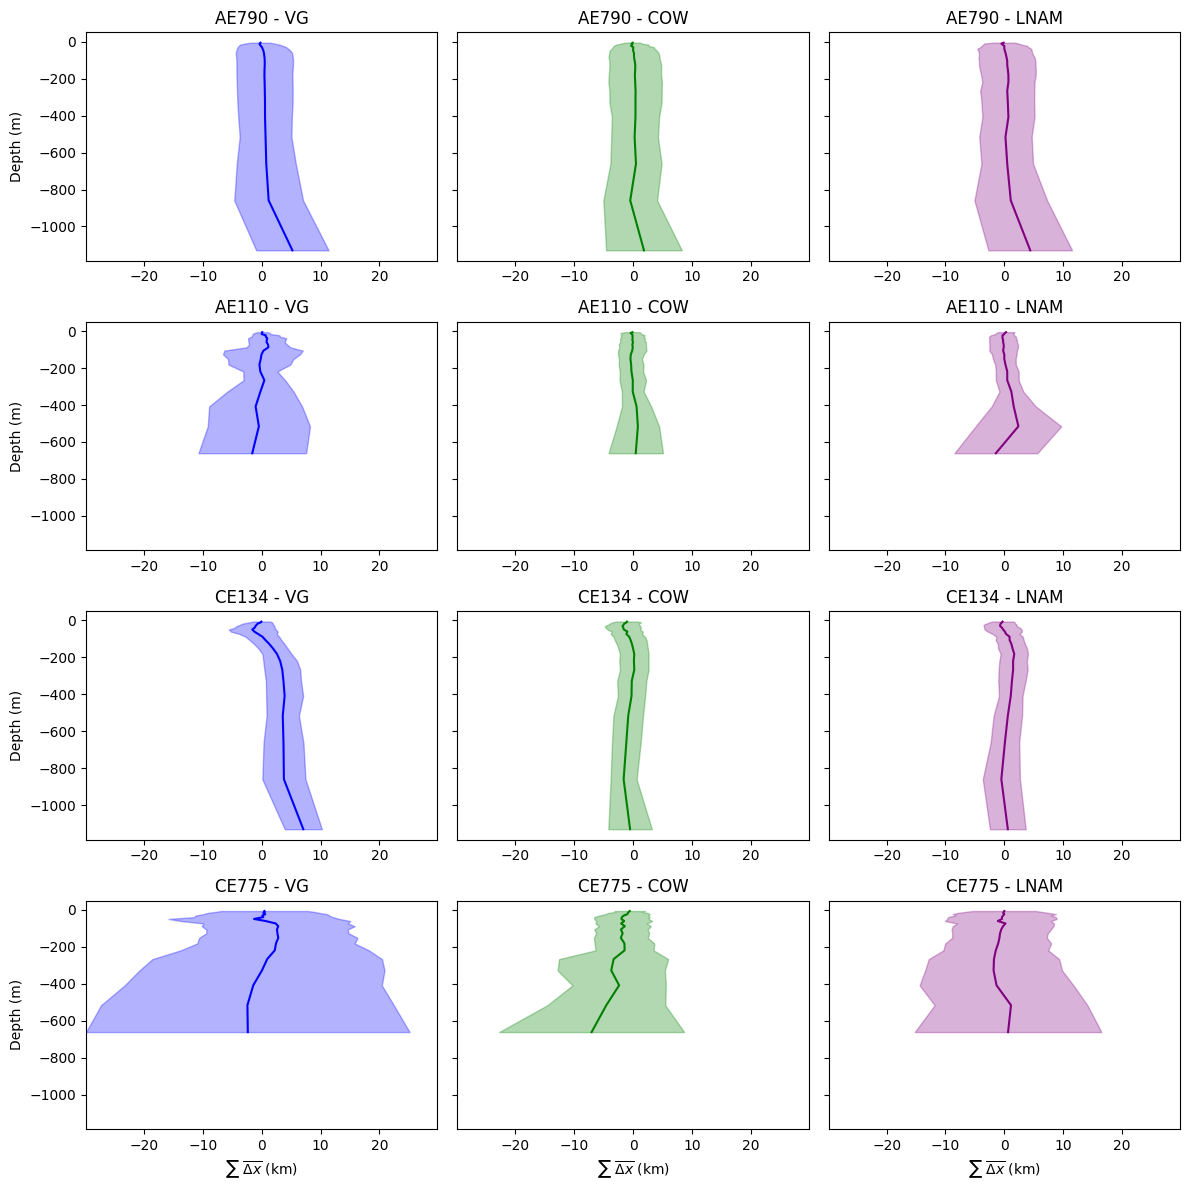

In [5]:
method_colors = {'VG': 'blue', 'COW': 'green', 'LNAM': 'purple'}

fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharey=True)

xmin = xmax = 0
for i, eddy in enumerate(the_frontier_eddies):
    for j, (method, color) in enumerate(method_colors.items()):
        ax = axes[i, j]

        x_df = pd.DataFrame()
        for t in range(30):
            x_data = frontier_sample_data[eddy][f'T{t}'][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['x']
            max_len = max(len(x_df), len(x_data))
            x_df = x_df.reindex(range(max_len)) 
            x_df[f'T{t}'] = pd.Series(x_data)
        x_df = x_df.dropna(thresh=10) # must have at least 10 non-NaNs
        
        x_mean, x_std = x_df.diff().cumsum().mean(axis=1)/1000, x_df.diff().cumsum().std(axis=1)/1000
        ax.plot(x_mean, z_r[150, 150, :len(x_mean)], color=color)
        ax.fill_betweenx(z_r[150, 150, :len(x_mean)], x_mean - x_std, x_mean + x_std, color=color, alpha=0.3)
        cyc = 'AE' if eddies[eddy].iloc[0]['Vort'] > 0 else 'CE'
        ax.set_title(cyc + str(extract_number(eddy)) + ' - ' + method)
        if j == 0: ax.set_ylabel("Depth (m)")
        if i == 3: ax.set_xlabel(r"$\sum\ \overline{\Delta x}$ (km)")

        xmin = min(np.nanmin(x_mean - x_std), xmin)
        xmax = max(np.nanmax(x_mean + x_std), xmax)

# Set common x-axis limits
xabs = max(abs(xmin), abs(xmax))
x_lim = [-xabs, xabs]
for ax in axes.flat:
    ax.set_xlim(x_lim)

plt.tight_layout()
plt.show()

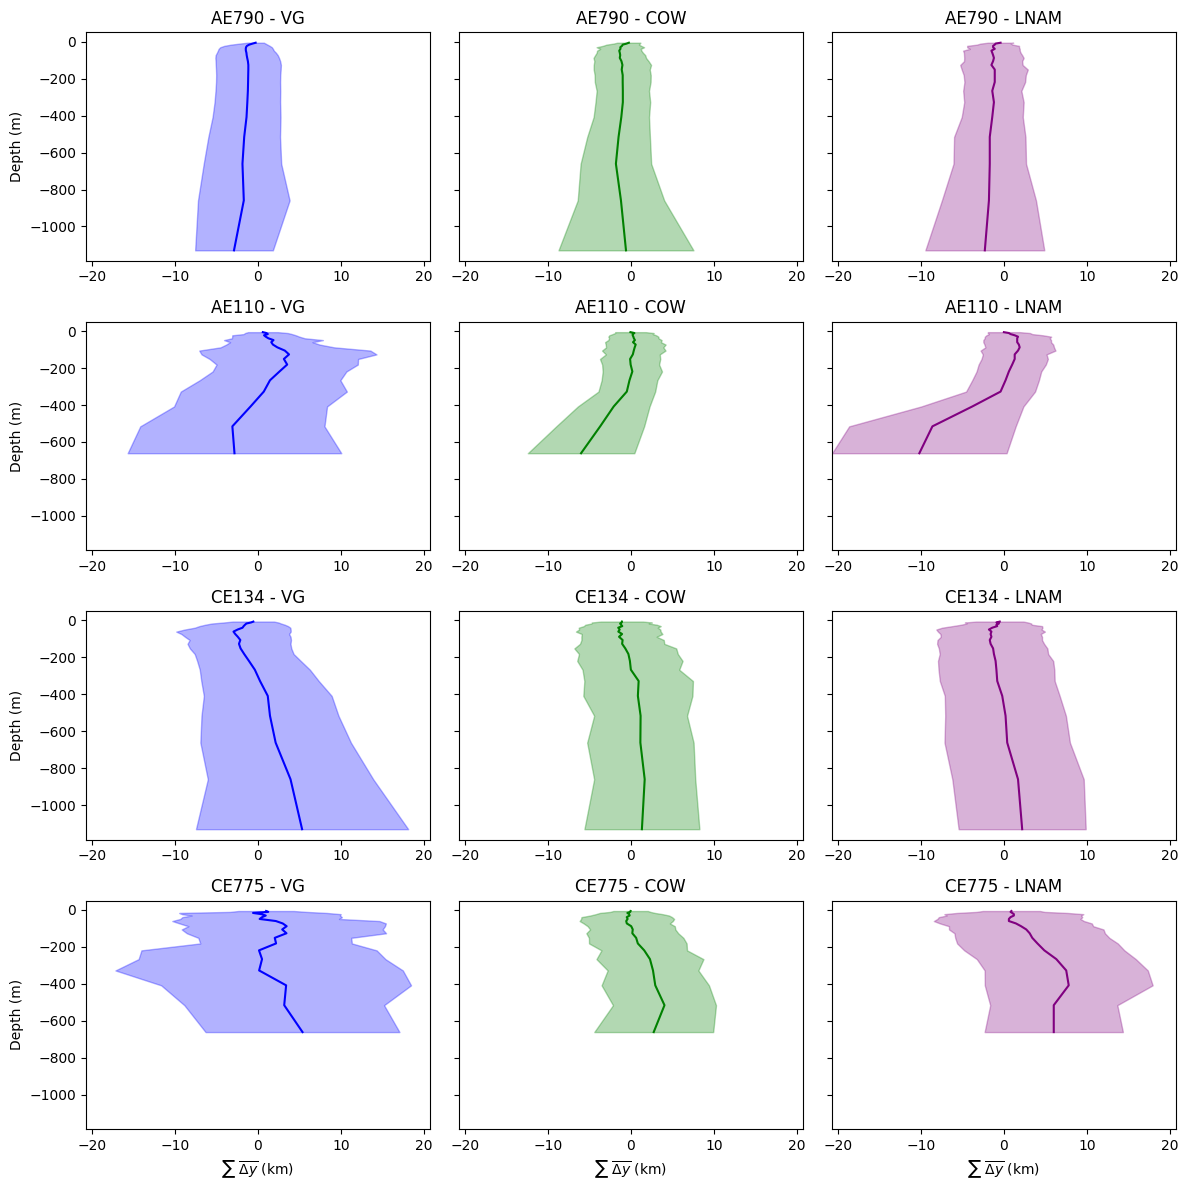

In [6]:
method_colors = {'VG': 'blue', 'COW': 'green', 'LNAM': 'purple'}

fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharey=True)

xmin = xmax = 0
for i, eddy in enumerate(the_frontier_eddies):
    for j, (method, color) in enumerate(method_colors.items()):
        ax = axes[i, j]
        
        y_df = pd.DataFrame()
        for t in range(30):
            y_data = frontier_sample_data[eddy][f'T{t}'][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['y']
            max_len = max(len(y_df), len(y_data))
            y_df = y_df.reindex(range(max_len)) 
            y_df[f'T{t}'] = pd.Series(y_data)
        y_df = y_df.dropna(thresh=10) # must have at least 10 non-NaNs
        
        y_mean, y_std = y_df.diff().cumsum().mean(axis=1)/1000, y_df.diff().cumsum().std(axis=1)/1000
        ax.plot(y_mean, z_r[150, 150, :len(y_mean)], color=color)
        ax.fill_betweenx(z_r[150, 150, :len(y_mean)], y_mean - y_std, y_mean + y_std, color=color, alpha=0.3)
        cyc = 'AE' if eddies[eddy].iloc[0]['Vort'] > 0 else 'CE'
        ax.set_title(cyc + str(extract_number(eddy)) + ' - ' + method)
        if j == 0: ax.set_ylabel("Depth (m)")
        if i == 3: ax.set_xlabel(r"$\sum\ \overline{\Delta y}$ (km)")

        xmin = min(np.nanmin(y_mean - y_std), xmin)
        xmax = max(np.nanmax(y_mean + y_std), xmax)

# Set common x-axis limits
xabs = max(abs(xmin), abs(xmax))
x_lim = [-xabs, xabs]
for ax in axes.flat:
    ax.set_xlim(x_lim)

plt.tight_layout()
plt.show()

## Covariance Analysis

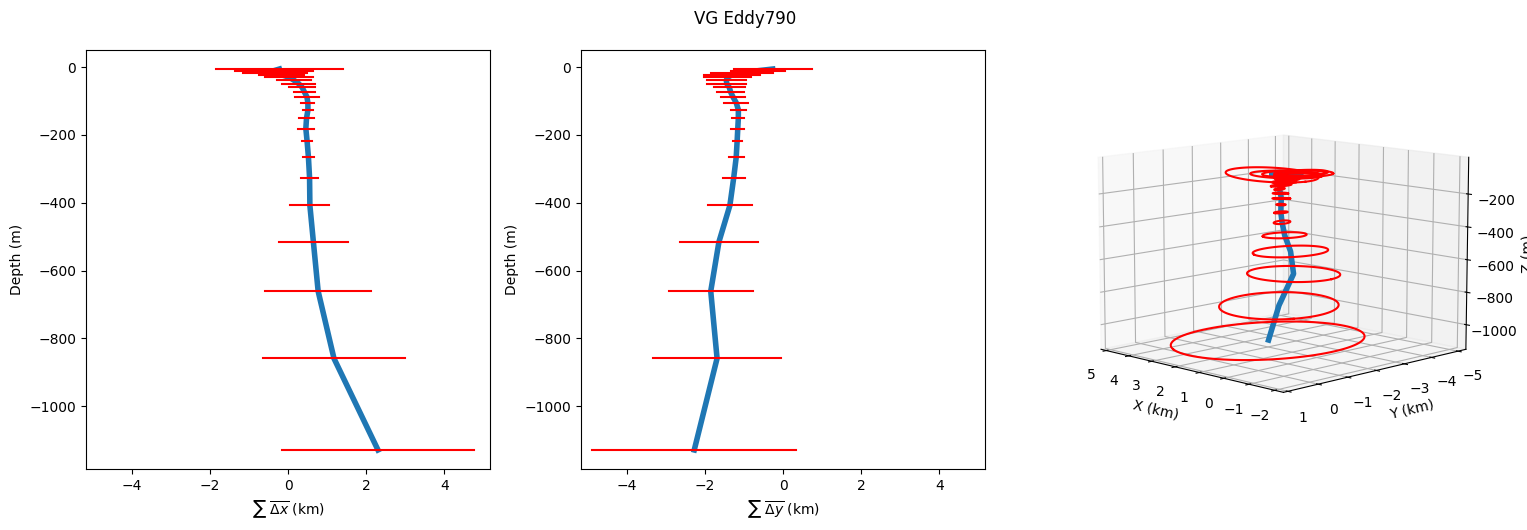

In [7]:
# PLOTS ARE BASED OFF VARIANCE ELLIPSE

eddy = the_frontier_eddies[0]

method = 'VG'

# create x and y dataframes 
x_df = pd.DataFrame()
y_df = pd.DataFrame()
for t in range(30):
    x_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['x'])/1000
    y_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['y'])/1000

    max_len = max(len(x_df), len(x_data))
    x_df = x_df.reindex(range(max_len)) 
    y_df = y_df.reindex(range(max_len))
    x_df[f'T{t}'] = pd.Series(x_data)
    y_df[f'T{t}'] = pd.Series(y_data)
x_df = x_df.dropna(thresh=10) # must have at least 10 non-NaNs
y_df = y_df.dropna(thresh=10) # must have at least 10 non-NaNs

# calcualte covariance matrices
Cz = np.full((2, 2, x_df.shape[0]), np.nan)
for k in range(1, x_df.shape[0]):
    x = x_df.diff().iloc[k]
    x = x.loc[~np.isnan(x)]
    y = y_df.diff().iloc[k]
    y = y.loc[~np.isnan(y)]
    Cz[:, :, k] = np.cov(np.stack([x.values, y.values]))
# plot 
x = x_df.diff().mean(axis=1).cumsum()
y = y_df.diff().mean(axis=1).cumsum()
fig = plt.figure(figsize=(15, 5))
ax = [fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133, projection='3d')]
ax[0].plot(x, z_r[150, 150, :len(x)], linewidth=4)
ax[1].plot(y, z_r[150, 150, :len(x)], linewidth=4)
ax[2].plot(x, y, z_r[150, 150, :len(x)], linewidth=4)
for k in range(len(x)):
    C = Cz[:, :, k]
    eigvals, eigvecs = np.linalg.eigh(C)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])
    axis_lengths = np.sqrt(eigvals)
    t = np.linspace(0, 2 * np.pi, 100)
    ellipse_points = np.array([np.cos(t), np.sin(t)]) * axis_lengths[:, np.newaxis]
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    ellipse_points = rotation_matrix.dot(ellipse_points)
    ax[0].plot([np.min(ellipse_points[0, :] + x[k]), np.max(ellipse_points[0, :] + x[k])], [z_r[150, 150, k], z_r[150, 150, k]], color='r')
    ax[1].plot([np.min(ellipse_points[1, :] + y[k]), np.max(ellipse_points[1, :] + y[k])], [z_r[150, 150, k], z_r[150, 150, k]], color='r')
    ax[2].plot(ellipse_points[0, :] + x[k], ellipse_points[1, :] + y[k], [z_r[150, 150, k]] * len(ellipse_points[0, :]), color='r')

xabs = max(max(np.abs(ax[0].get_xlim())), max(np.abs(ax[1].get_xlim())))
ax[0].set_xlim([-xabs, xabs])
ax[1].set_xlim([-xabs, xabs])

ax[2].view_init(elev=10, azim=135)
ax[0].set_xlabel(r'$\sum\ \overline{\Delta x}$ (km)')
ax[1].set_xlabel(r'$\sum\ \overline{\Delta y}$ (km)')
ax[0].set_ylabel('Depth (m)')
ax[1].set_ylabel('Depth (m)')
ax[2].set_xlabel('X (km)')
ax[2].set_ylabel('Y (km)')
ax[2].set_zlabel('Z (m)')
plt.tight_layout()
plt.suptitle(method + ' ' + eddy, y=1.05)
plt.show()



#### Individual x and y analysis

-412.79859693896447
-214.97801493036414
-126.28812668734147


/scratch/pbs.6060951.kman.restech.unsw.edu.au/ipykernel_3625441/2193831329.py:75: RankWarning: Polyfit may be poorly conditioned
  coefficients_x = np.polyfit(x, z, 1, w=wx)


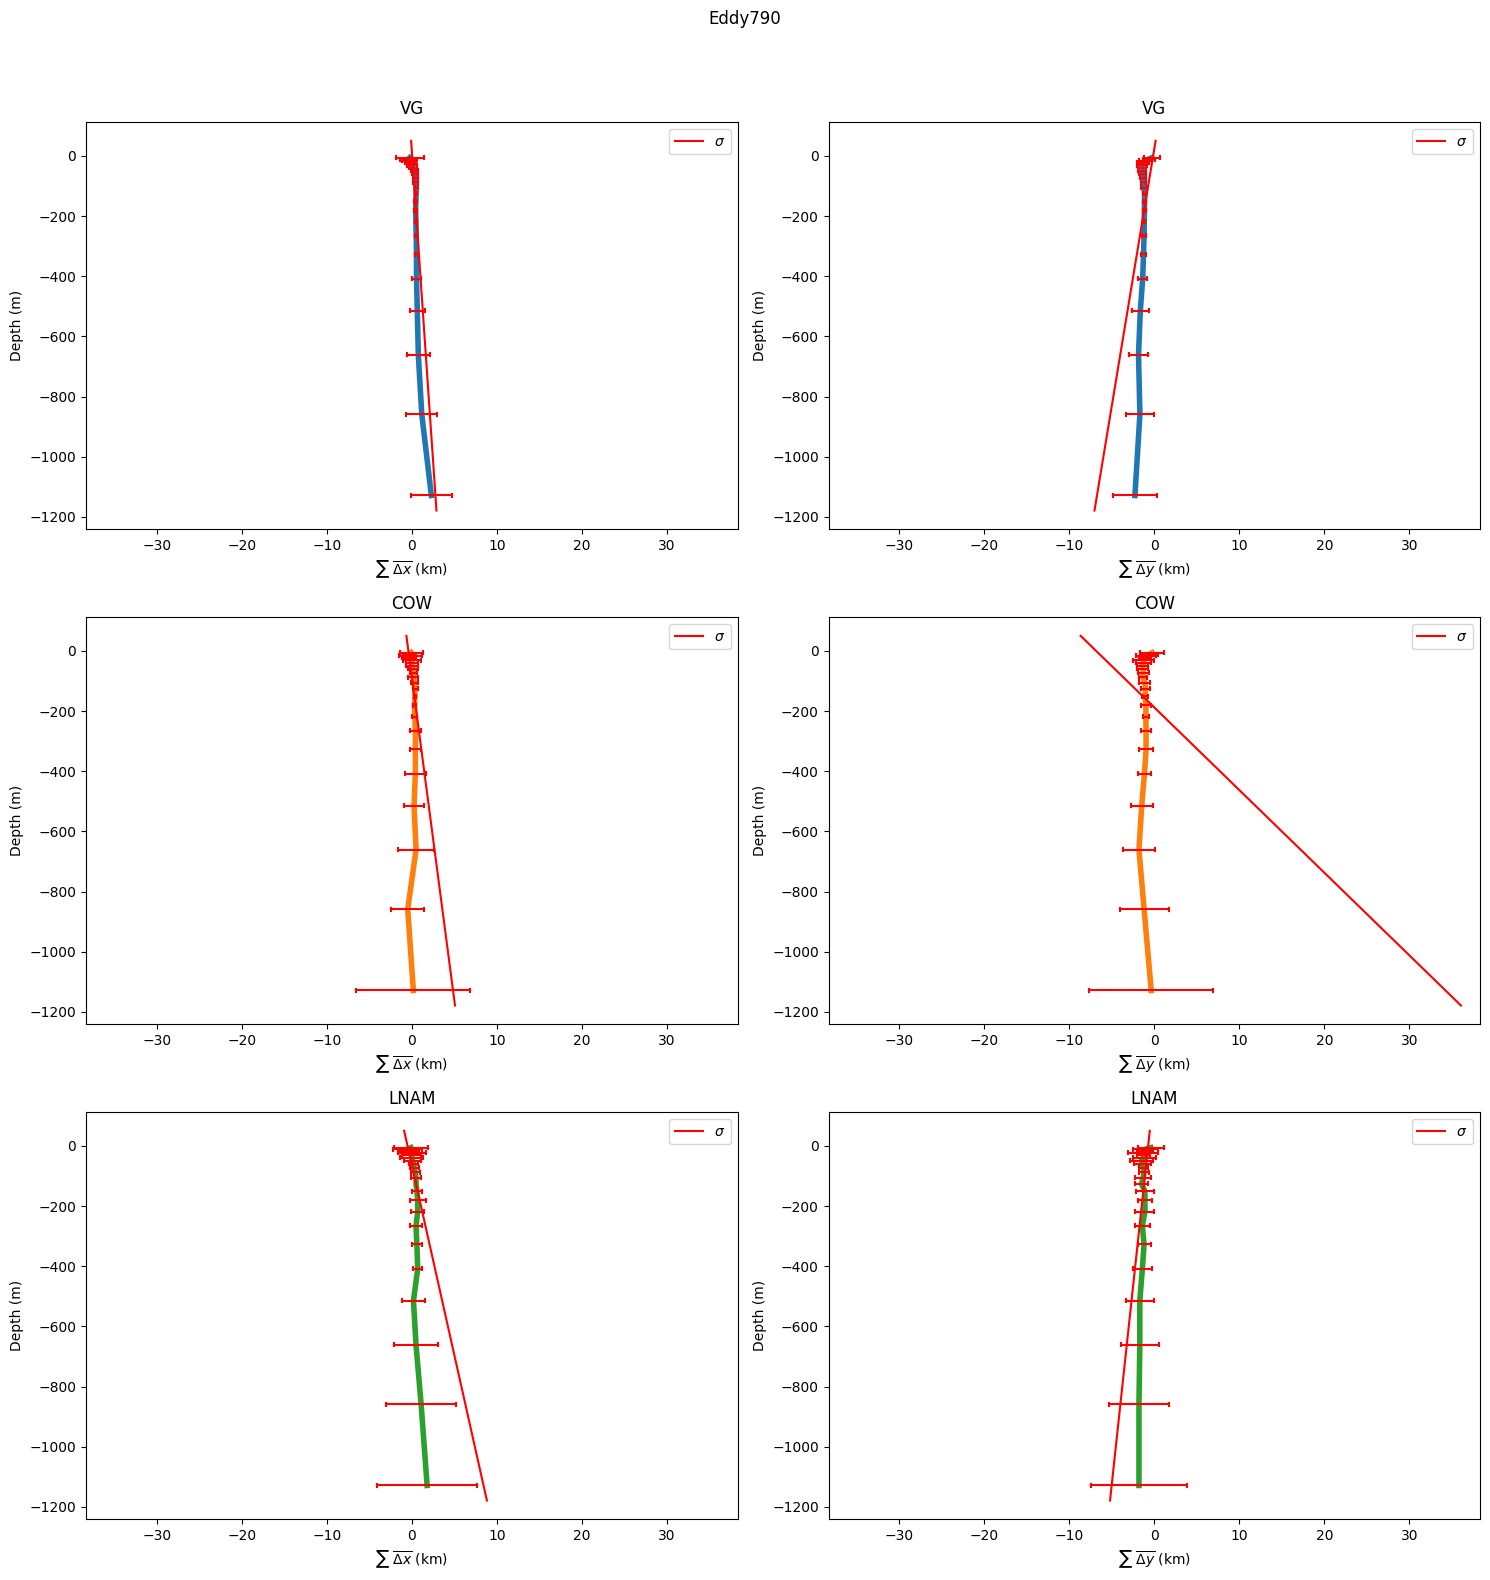

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  

eddy = the_frontier_eddies[0]

colors = plt.cm.tab10.colors
slopes_x, slopes_y = [], []
for row, method in enumerate(['VG', 'COW', 'LNAM']):
    # create x and y dataframes 
    x_df = pd.DataFrame()
    y_df = pd.DataFrame()
    for t in range(30):
        x_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['x'])/1000
        y_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['y'])/1000
    
        max_len = max(len(x_df), len(x_data))
        x_df = x_df.reindex(range(max_len)) 
        y_df = y_df.reindex(range(max_len))
        x_df[f'T{t}'] = pd.Series(x_data)
        y_df[f'T{t}'] = pd.Series(y_data)
    x_df = x_df.dropna(thresh=10) # must have at least 10 non-NaNs
    y_df = y_df.dropna(thresh=10) # must have at least 10 non-NaNs

    # Calculate covariance matrices
    Cz = np.full((2, 2, x_df.shape[0]), np.nan)
    for k in range(1, x_df.shape[0]):
        x = x_df.diff().iloc[k]
        x = x.loc[~np.isnan(x)]
        y = y_df.diff().iloc[k]
        y = y.loc[~np.isnan(y)]
        Cz[:, :, k] = np.cov(np.stack([x.values, y.values]))
    # Plot 
    x = x_df.diff().mean(axis=1).cumsum()
    y = y_df.diff().mean(axis=1).cumsum()
    # Select the row for each method in the 3x2 plot
    ax_x = axes[row, 0]  # X plot
    ax_y = axes[row, 1]  # Y plot
    
    ax_x.plot(x, z_r[150, 150, :len(x)], linewidth=4, color=colors[row])
    ax_y.plot(y, z_r[150, 150, :len(x)], linewidth=4, color=colors[row])
    
    x_error = []
    y_error = []
    z = []
    for k in range(1, len(x)):
        C = Cz[:, :, k]

        if not C[0,0] == 0:
            sigx = np.sqrt(C[0,0])
        else:
            sigx = np.finfo(float).eps
        if not C[1,1] == 0:
            sigy = np.sqrt(C[1,1])
        else:
            sigy = np.finfo(float).eps
            
        x_error.append(sigx)
        y_error.append(sigy)

        edge_len = 5
        ax_x.plot([x[k] - sigx, x[k] + sigx], [z_r[150, 150, k], z_r[150, 150, k]], label=r'$\sigma$' if k == 1 else None, color='r') 
        ax_x.plot([x[k] - sigx, x[k] - sigx], [z_r[150, 150, k] - edge_len, z_r[150, 150, k] + edge_len], color='r')
        ax_x.plot([x[k] + sigx, x[k] + sigx], [z_r[150, 150, k] - edge_len, z_r[150, 150, k] + edge_len], color='r')
        ax_y.plot([y[k] - sigy, y[k] + sigy], [z_r[150, 150, k], z_r[150, 150, k]], label=r'$\sigma$' if k == 1 else None, color='r')
        ax_y.plot([y[k] - sigy, y[k] - sigy], [z_r[150, 150, k] - edge_len, z_r[150, 150, k] + edge_len], color='r')
        ax_y.plot([y[k] + sigy, y[k] + sigy], [z_r[150, 150, k] - edge_len, z_r[150, 150, k] + edge_len], color='r')
        z.append(z_r[150, 150, k])

    wx = 1/np.array(x_error)
    wy = 1/np.array(y_error)
    x = x[1:]
    y = y[1:]
    
    z_top = 50
    z_btm = z[-1] - 50
    coefficients_x = np.polyfit(x, z, 1, w=wx)
    slope_x, intercept_x = coefficients_x
    print(slope_x)
    slopes_x.append(slope_x)
    coefficients_y = np.polyfit(y, z, 1, w=wy)
    slope_y, intercept_y = coefficients_y
    slopes_y.append(slope_y)
    x_btm = (z_btm - intercept_x) / slope_x
    x_top = (z_top - intercept_x) / slope_x
    y_btm = (z_btm - intercept_y) / slope_y
    y_top = (z_top - intercept_y) / slope_y
    ax_x.plot([x_btm, x_top], [z_btm, z_top], color='red')
    ax_y.plot([y_btm, y_top], [z_btm, z_top], color='red')
    ax_x.set_xlabel(r'$\sum\ \overline{\Delta x}$ (km)')
    ax_y.set_xlabel(r'$\sum\ \overline{\Delta y}$ (km)')
    ax_x.set_ylabel('Depth (m)')
    ax_y.set_ylabel('Depth (m)')
    ax_x.set_title(f'{method}')
    ax_y.set_title(f'{method}')
    ax_x.legend(loc='upper right')
    ax_y.legend(loc='upper right')

xlims = [ax.get_xlim() for ax in axes.ravel()]
abs_xlims = sorted([abs(val) for lim in xlims for val in lim], reverse=True)
threshold = 40
final_xlim = abs_xlims[0]
for abs_xlim in abs_xlims:
    if abs_xlim <= threshold:
        final_xlim = abs_xlim
        break
for ax in axes.ravel():
    ax.set_xlim(-final_xlim, final_xlim)

plt.tight_layout()
plt.suptitle(f'{eddy}', y=1.05)
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Create a 3x2 grid of subplots

eddy = the_frontier_eddies[0]

colors = plt.cm.tab10.colors
slopes_x, slopes_y = [], []
for row, method in enumerate(['VG', 'COW', 'LNAM']):
    # create x and y dataframes 
    x_df = pd.DataFrame()
    y_df = pd.DataFrame()
    for t in range(30):
        x_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['x'])/1000
        y_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['y'])/1000
    
        max_len = max(len(x_df), len(x_data))
        x_df = x_df.reindex(range(max_len)) 
        y_df = y_df.reindex(range(max_len))
        x_df[f'T{t}'] = pd.Series(x_data)
        y_df[f'T{t}'] = pd.Series(y_data)
    x_df = x_df.dropna(thresh=10) # must have at least 10 non-NaNs
    y_df = y_df.dropna(thresh=10) # must have at least 10 non-NaNs

    # Calculate covariance matrices
    Cz = np.full((2, 2, x_df.shape[0]), np.nan)
    for k in range(1, x_df.shape[0]):
        x = x_df.diff().iloc[k]
        x = x.loc[~np.isnan(x)]
        y = y_df.diff().iloc[k]
        y = y.loc[~np.isnan(y)]
        Cz[:, :, k] = np.cov(np.stack([x.values, y.values]))
    # Plot 
    x = x_df.diff().mean(axis=1).cumsum()
    y = y_df.diff().mean(axis=1).cumsum()
    # Select the row for each method in the 3x2 plot
    ax_x = axes[row, 0]  # X plot
    ax_y = axes[row, 1]  # Y plot
    
    ax_x.plot(x, z_r[150, 150, :len(x)], linewidth=4, color=colors[row])
    ax_y.plot(y, z_r[150, 150, :len(x)], linewidth=4, color=colors[row])
    
    x_error = []
    y_error = []
    z = []
    for k in range(1, len(x)):
        C = Cz[:, :, k]

        if not C[0,0] == 0:
            sigx = np.sqrt(C[0,0])
        else:
            sigx = np.finfo(float).eps
        if not C[1,1] == 0:
            sigy = np.sqrt(C[1,1])
        else:
            sigy = np.finfo(float).eps
        x_error.append(sigx)
        y_error.append(sigy)
        
        z.append(z_r[150, 150, k])

    x = x[1:]
    y = y[1:]

    # Interpolation and polynomial fitting process
    x_error_original = x_error
    y_error_original = y_error
    x_original = x
    y_original = y
    z_original = z
    num = 30 #len(z)
    z_new = np.flip(np.linspace(np.min(z), np.max(z), num=num))
    interpolate_func = interp1d(z_original, x_error_original, kind='linear', fill_value="extrapolate")
    x_error_new = interpolate_func(z_new)
    interpolate_func = interp1d(z_original, y_error_original, kind='linear', fill_value="extrapolate")
    y_error_new = interpolate_func(z_new)
    interpolate_func = interp1d(z_original, x_original, kind='linear', fill_value="extrapolate")
    x_new = interpolate_func(z_new)
    interpolate_func = interp1d(z_original, y_original, kind='linear', fill_value="extrapolate")
    y_new = interpolate_func(z_new)
    x_error = x_error_new
    y_error = y_error_new
    
    wx = 1/np.array(x_error)
    wy = 1/np.array(y_error)

    x = x_new
    y = y_new
    z = z_new

    for k in range(len(x)):
        sigx = x_error[k]
        sigy = y_error[k]
        edge_len = 5
        ax_x.plot([x[k] - sigx, x[k] + sigx], [z[k], z[k]], label=r'$\sigma$' if k == 1 else None, color='r')
        ax_x.plot([x[k] - sigx, x[k] - sigx], [z[k] - edge_len, z[k] + edge_len], color='r')
        ax_x.plot([x[k] + sigx, x[k] + sigx], [z[k] - edge_len, z[k] + edge_len], color='r')
        ax_y.plot([y[k] - sigy, y[k] + sigy], [z[k], z[k]], label=r'$\sigma$' if k == 1 else None, color='r')
        ax_y.plot([y[k] - sigy, y[k] - sigy], [z[k] - edge_len, z[k] + edge_len], color='r')
        ax_y.plot([y[k] + sigy, y[k] + sigy], [z[k] - edge_len, z[k] + edge_len], color='r')

    z_top = 50
    z_btm = z[-1] - 50
    coefficients_x = np.polyfit(x, z, 1, w=wx)
    slope_x, intercept_x = coefficients_x
    print(slope_x)
    slopes_x.append(slope_x)
    coefficients_y = np.polyfit(y, z, 1, w=wy)
    slope_y, intercept_y = coefficients_y
    slopes_y.append(slope_y)
    x_btm = (z_btm - intercept_x) / slope_x
    x_top = (z_top - intercept_x) / slope_x
    y_btm = (z_btm - intercept_y) / slope_y
    y_top = (z_top - intercept_y) / slope_y
    ax_x.plot([x_btm, x_top], [z_btm, z_top], color='red')
    ax_y.plot([y_btm, y_top], [z_btm, z_top], color='red')
    ax_x.set_xlabel(r'$\sum\ \overline{\Delta x}$ (km)')
    ax_y.set_xlabel(r'$\sum\ \overline{\Delta y}$ (km)')
    ax_x.set_ylabel('Depth (m)')
    ax_y.set_ylabel('Depth (m)')
    ax_x.set_title(f'{method}')
    ax_y.set_title(f'{method}')
    ax_x.legend(loc='upper right')
    ax_y.legend(loc='upper right')

xlims = [ax.get_xlim() for ax in axes.ravel()]
abs_xlims = sorted([abs(val) for lim in xlims for val in lim], reverse=True)
threshold = 40
final_xlim = abs_xlims[0]
for abs_xlim in abs_xlims:
    if abs_xlim <= threshold:
        final_xlim = abs_xlim
        break
for ax in axes.ravel():
    ax.set_xlim(-final_xlim, final_xlim)
    
plt.tight_layout()
plt.suptitle(f'{eddy}', y=1.05)
plt.show()

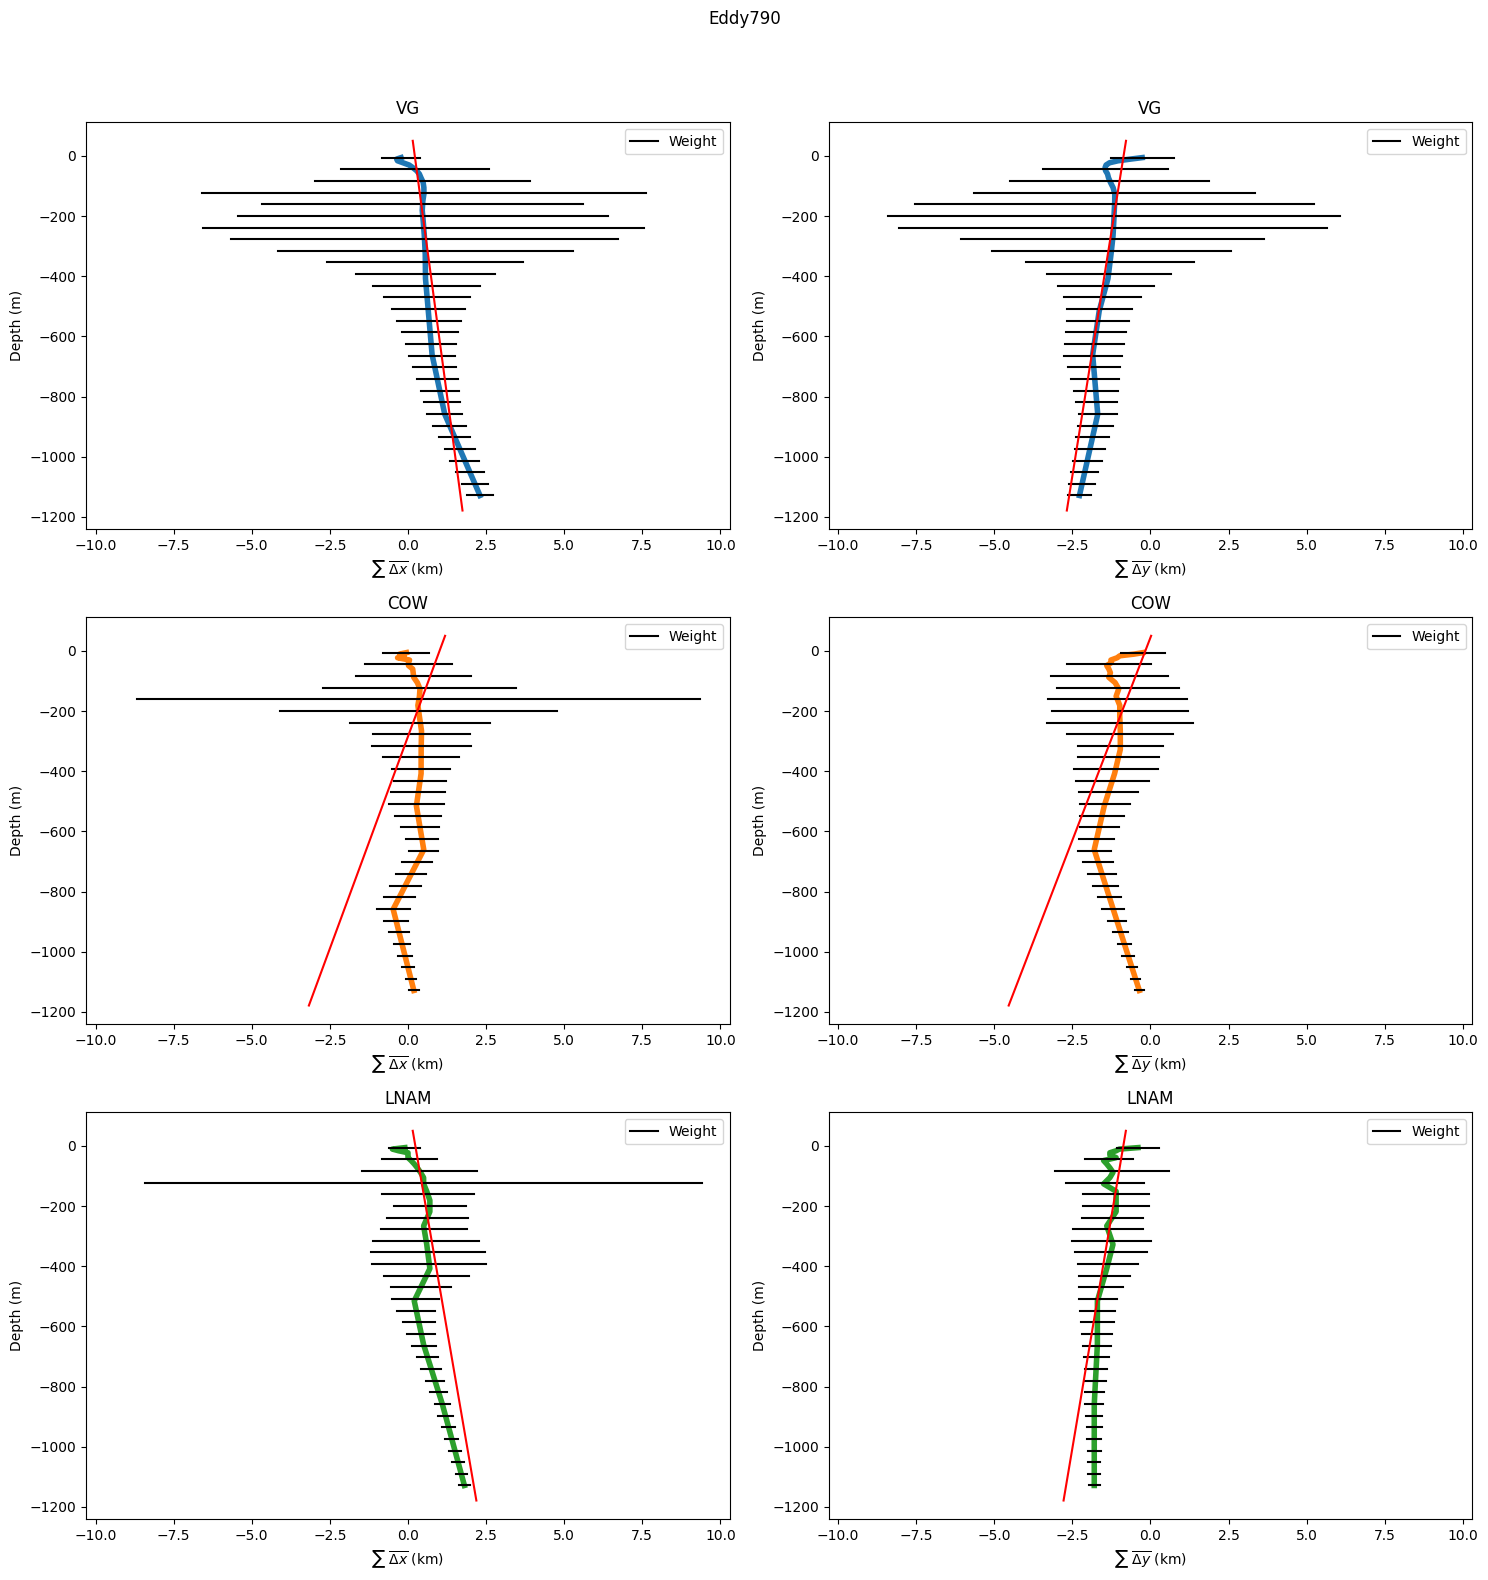

In [12]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))  # Create a 3x2 grid of subplots

eddy = the_frontier_eddies[0]

colors = plt.cm.tab10.colors
slopes_x, slopes_y = [], []
for row, method in enumerate(['VG', 'COW', 'LNAM']):
    # create x and y dataframes 
    x_df = pd.DataFrame()
    y_df = pd.DataFrame()
    for t in range(30):
        x_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['x'])/1000
        y_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['y'])/1000
    
        max_len = max(len(x_df), len(x_data))
        x_df = x_df.reindex(range(max_len)) 
        y_df = y_df.reindex(range(max_len))
        x_df[f'T{t}'] = pd.Series(x_data)
        y_df[f'T{t}'] = pd.Series(y_data)
    x_df = x_df.dropna(thresh=10) # must have at least 10 non-NaNs
    y_df = y_df.dropna(thresh=10) # must have at least 10 non-NaNs

    # Calculate covariance matrices
    Cz = np.full((2, 2, x_df.shape[0]), np.nan)
    for k in range(1, x_df.shape[0]):
        x = x_df.diff().iloc[k]
        x = x.loc[~np.isnan(x)]
        y = y_df.diff().iloc[k]
        y = y.loc[~np.isnan(y)]
        Cz[:, :, k] = np.cov(np.stack([x.values, y.values]))
    # Plot 
    x = x_df.diff().mean(axis=1).cumsum()
    y = y_df.diff().mean(axis=1).cumsum()
    # Select the row for each method in the 3x2 plot
    ax_x = axes[row, 0]  # X plot
    ax_y = axes[row, 1]  # Y plot
    
    ax_x.plot(x, z_r[150, 150, :len(x)], linewidth=4, color=colors[row])
    ax_y.plot(y, z_r[150, 150, :len(x)], linewidth=4, color=colors[row])
    
    x_error = []
    y_error = []
    z = []
    for k in range(1, len(x)):
        C = Cz[:, :, k]

        if not C[0,0] == 0:
            sigx = np.sqrt(C[0,0])
        else:
            sigx = np.finfo(float).eps
        if not C[1,1] == 0:
            sigy = np.sqrt(C[1,1])
        else:
            sigy = np.finfo(float).eps
        x_error.append(sigx)
        y_error.append(sigy)
        
        z.append(z_r[150, 150, k])

    x = x[1:]
    y = y[1:]

    # Interpolation and polynomial fitting process
    x_error_original = x_error
    y_error_original = y_error
    x_original = x
    y_original = y
    z_original = z
    num = 30 #len(z)
    z_new = np.flip(np.linspace(np.min(z), np.max(z), num=num))
    interpolate_func = interp1d(z_original, x_error_original, kind='linear', fill_value="extrapolate")
    x_error_new = interpolate_func(z_new)
    interpolate_func = interp1d(z_original, y_error_original, kind='linear', fill_value="extrapolate")
    y_error_new = interpolate_func(z_new)
    interpolate_func = interp1d(z_original, x_original, kind='linear', fill_value="extrapolate")
    x_new = interpolate_func(z_new)
    interpolate_func = interp1d(z_original, y_original, kind='linear', fill_value="extrapolate")
    y_new = interpolate_func(z_new)
    x_error = x_error_new
    y_error = y_error_new
    
    wx = 1/np.array(x_error)
    wy = 1/np.array(y_error)

    x = x_new
    y = y_new
    z = z_new

    for k in range(len(x)):
        sigx = wx[k]
        sigy = wy[k]
        edge_len = 5
        ax_x.plot([x[k] - sigx, x[k] + sigx], [z[k], z[k]], label='Weight' if k == 1 else None, color='k')
        # ax_x.plot([x[k] - sigx, x[k] - sigx], [z[k] - edge_len, z[k] + edge_len], color='k')
        # ax_x.plot([x[k] + sigx, x[k] + sigx], [z[k] - edge_len, z[k] + edge_len], color='k')
        ax_y.plot([y[k] - sigy, y[k] + sigy], [z[k], z[k]], label='Weight' if k == 1 else None, color='k')
        # ax_y.plot([y[k] - sigy, y[k] - sigy], [z[k] - edge_len, z[k] + edge_len], color='k')
        # ax_y.plot([y[k] + sigy, y[k] + sigy], [z[k] - edge_len, z[k] + edge_len], color='k')
    
    z_top = 50
    z_btm = z[-1] - 50
    coefficients_x = np.polyfit(x, z, 1, w=wx)
    slope_x, intercept_x = coefficients_x
    slopes_x.append(slope_x)
    coefficients_y = np.polyfit(y, z, 1, w=wy)
    slope_y, intercept_y = coefficients_y
    slopes_y.append(slope_y)
    x_btm = (z_btm - intercept_x) / slope_x
    x_top = (z_top - intercept_x) / slope_x
    y_btm = (z_btm - intercept_y) / slope_y
    y_top = (z_top - intercept_y) / slope_y
    ax_x.plot([x_btm, x_top], [z_btm, z_top], color='red')
    ax_y.plot([y_btm, y_top], [z_btm, z_top], color='red')


    ax_x.set_xlabel(r'$\sum\ \overline{\Delta x}$ (km)')
    ax_y.set_xlabel(r'$\sum\ \overline{\Delta y}$ (km)')
    ax_x.set_ylabel('Depth (m)')
    ax_y.set_ylabel('Depth (m)')
    ax_x.set_title(f'{method}')
    ax_y.set_title(f'{method}')
    ax_x.legend(loc='upper right')
    ax_y.legend(loc='upper right')

xlims = [ax.get_xlim() for ax in axes.ravel()]
abs_xlims = sorted([abs(val) for lim in xlims for val in lim], reverse=True)
threshold = 40
final_xlim = abs_xlims[0]
for abs_xlim in abs_xlims:
    if abs_xlim <= threshold:
        final_xlim = abs_xlim
        break
for ax in axes.ravel():
    ax.set_xlim(-final_xlim, final_xlim)
    
plt.tight_layout()
plt.suptitle(f'{eddy}', y=1.05)
plt.show()

### PAV with weight determined by covariance

In [62]:
eddy = the_frontier_eddies[2]
method = 'VG'

# create x and y dataframes 
x_df = pd.DataFrame()
y_df = pd.DataFrame()
for t in range(30):
    x_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['x'])/1000
    y_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['y'])/1000

    max_len = max(len(x_df), len(x_data))
    x_df = x_df.reindex(range(max_len)) 
    y_df = y_df.reindex(range(max_len))
    x_df[f'T{t}'] = pd.Series(x_data)
    y_df[f'T{t}'] = pd.Series(y_data)
x_df = x_df.dropna(thresh=10) # must have at least 10 non-NaNs
y_df = y_df.dropna(thresh=10) # must have at least 10 non-NaNs

# Calculate covariance matrices
Cz = np.full((2, 2, x_df.shape[0]), np.nan)
for k in range(1, x_df.shape[0]):
    x = x_df.diff().iloc[k]
    x = x.loc[~np.isnan(x)]
    y = y_df.diff().iloc[k]
    y = y.loc[~np.isnan(y)]
    Cz[:, :, k] = np.cov(np.stack([x.values, y.values]))
# Plot 
x = x_df.diff().mean(axis=1).cumsum()
y = y_df.diff().mean(axis=1).cumsum()
# Select the row for each method in the 3x2 plot
ax_x = axes[row, 0]  # X plot
ax_y = axes[row, 1]  # Y plot

ax_x.plot(x, z_r[150, 150, :len(x)], linewidth=4, color=colors[row])
ax_y.plot(y, z_r[150, 150, :len(x)], linewidth=4, color=colors[row])

sigxy = []
z = []
for k in range(1, len(x)):
    C = Cz[:, :, k]

    if not C[0,1] == 0:
        sigxy.append(np.sqrt(C[0,0]))
    else:
        sigxy.append(np.finfo(float).eps)

    z.append(z_r[150, 150, k])

x = np.array(x[1:])
y = np.array(y[1:])
z = np.array(z)

weights = 1 / np.array(sigxy)

# Design matrix
A = np.column_stack((x, y, np.ones_like(x)))

# Weight matrix
W = np.diag(weights)

# Weighted least squares computation
A_prime = np.linalg.cholesky(W) @ A
z_prime = np.linalg.cholesky(W) @ z

coeffs = np.linalg.lstsq(A_prime, z_prime, rcond=None)[0]

# Coefficients
a, b, c = coeffs
print(f"Fitted plane: z = {a:.2f} * x + {b:.2f} * y + {c:.2f}")


Fitted plane: z = -31.10 * x + -98.27 * y + -243.13


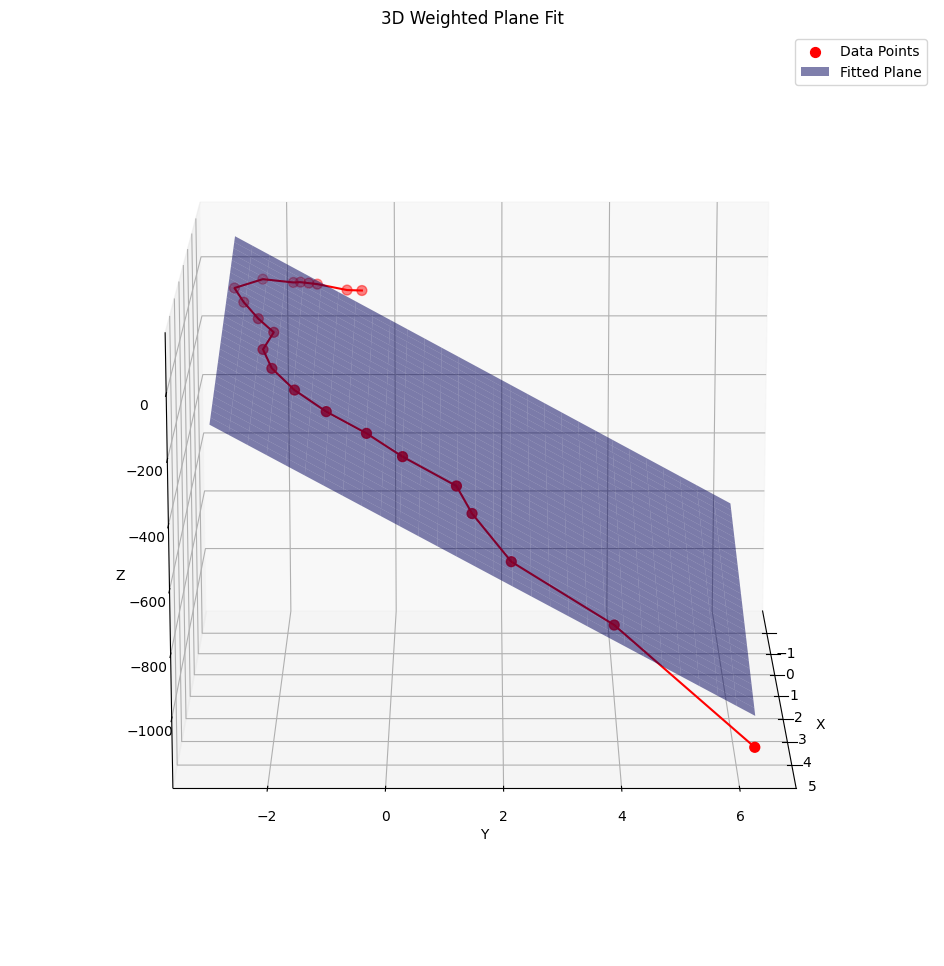

In [60]:

x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), 30),
                             np.linspace(min(y), max(y), 30))
z_grid = a * x_grid + b * y_grid + c

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color='red', label='Data Points', s=50)
ax.plot(x, y, z, color='red')

ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.5, color='blue', label='Fitted Plane')

ax.view_init(elev=15, azim=0)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Weighted Plane Fit')
plt.legend(loc='best')

plt.show()

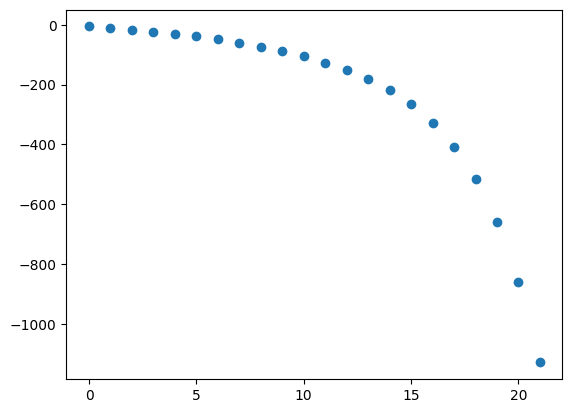

In [34]:
plt.scatter(np.arange(len(z)),z)

#### Analysis

In [21]:
methods = ['VG', 'COW', 'LNAM']
X_slope = pd.DataFrame(columns=methods)
Y_slope = pd.DataFrame(columns=methods)


for eddy in the_frontier_eddies:
    dfx = pd.DataFrame()
    dfy = pd.DataFrame()
    
    for method in methods:
    
        x_df = pd.DataFrame()
        y_df = pd.DataFrame()
        for t in range(30):
            x_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['x'])/1000
            y_data = (frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy]['T'+str(t)][method].iloc[0]['y'])/1000
        
            max_len = max(len(x_df), len(x_data))
            x_df = x_df.reindex(range(max_len)) 
            y_df = y_df.reindex(range(max_len))
            x_df[f'T{t}'] = pd.Series(x_data)
            y_df[f'T{t}'] = pd.Series(y_data)
        x_df = x_df.dropna(thresh=10) # must have at least 10 non-NaNs
        y_df = y_df.dropna(thresh=10) # must have at least 10 non-NaNs
    
        # Calculate covariance matrices
        Cz = np.full((2, 2, x_df.shape[0]), np.nan)
        for k in range(1, x_df.shape[0]):
            x = x_df.diff().iloc[k]
            x = x.loc[~np.isnan(x)]
            y = y_df.diff().iloc[k]
            y = y.loc[~np.isnan(y)]
            Cz[:, :, k] = np.cov(np.stack([x.values, y.values]))
        x = x_df.diff().mean(axis=1).cumsum()
        y = y_df.diff().mean(axis=1).cumsum()

        x_error = []
        y_error = []
        z = []
        for k in range(1, len(x)):
            C = Cz[:, :, k]
    
            if not C[0,0] == 0:
                sigx = np.sqrt(C[0,0])
            else:
                sigx = np.finfo(float).eps
            if not C[1,1] == 0:
                sigy = np.sqrt(C[1,1])
            else:
                sigy = np.finfo(float).eps
            x_error.append(sigx)
            y_error.append(sigy)
            
            z.append(z_r[150, 150, k])
    
        x = x[1:]
        y = y[1:]
    
        # Interpolation and polynomial fitting process
        x_error_original = x_error
        y_error_original = y_error
        x_original = x
        y_original = y
        z_original = z
        num = 30 #len(z)
        z_new = np.flip(np.linspace(np.min(z), np.max(z), num=num))
        interpolate_func = interp1d(z_original, x_error_original, kind='linear', fill_value="extrapolate")
        x_error_new = interpolate_func(z_new)
        interpolate_func = interp1d(z_original, y_error_original, kind='linear', fill_value="extrapolate")
        y_error_new = interpolate_func(z_new)
        interpolate_func = interp1d(z_original, x_original, kind='linear', fill_value="extrapolate")
        x_new = interpolate_func(z_new)
        interpolate_func = interp1d(z_original, y_original, kind='linear', fill_value="extrapolate")
        y_new = interpolate_func(z_new)
        x_error = x_error_new
        y_error = y_error_new
        
        wx = 1/np.array(x_error)
        wy = 1/np.array(y_error)
    
        x = x_new
        y = y_new
        z = z_new
        
        z_top = 50
        z_btm = z[-1] - 50
        coefficients_x = np.polyfit(x, z, 1, w=wx)
        slope_x, intercept_x = coefficients_x

        coefficients_y = np.polyfit(y, z, 1, w=wy)
        slope_y, intercept_y = coefficients_y

        dfx[method] = [slope_x/1000]
        dfy[method] = [slope_y/1000]
    
    X_slope.loc[eddy] = dfx.iloc[0]
    Y_slope.loc[eddy] = dfy.iloc[0]
    


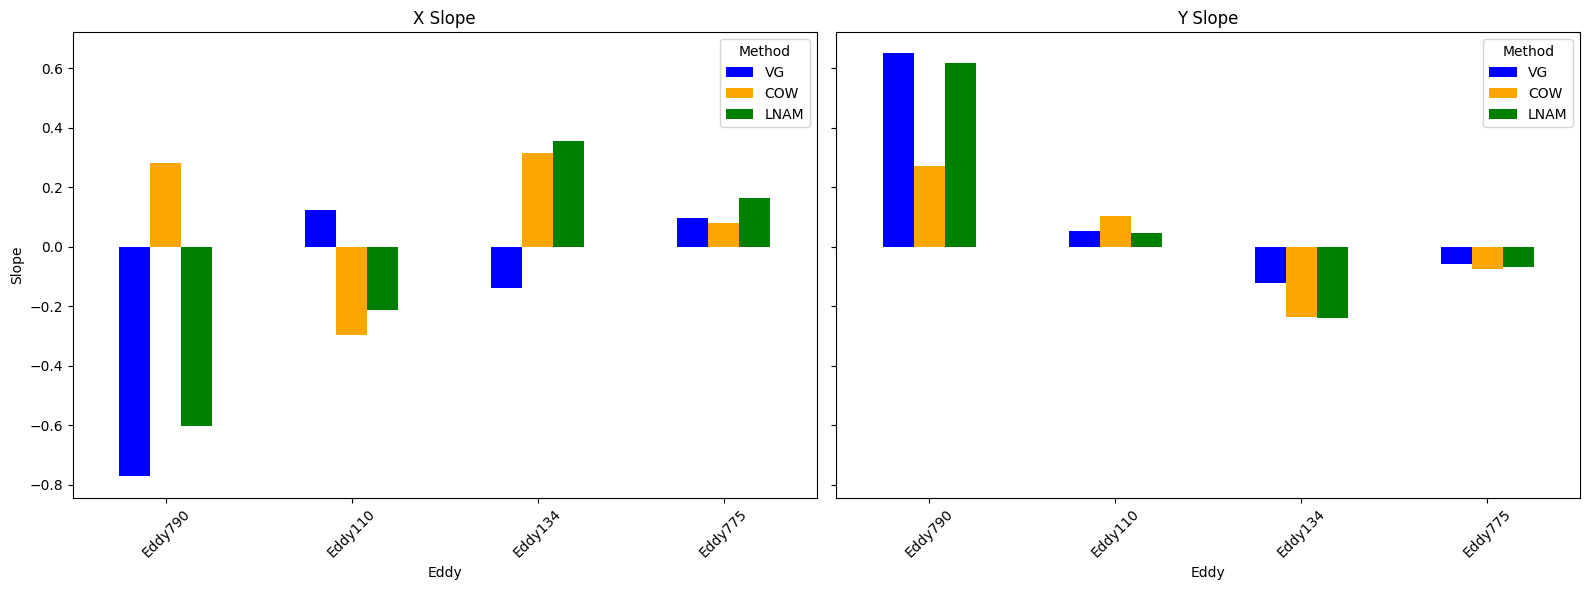

In [25]:

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot X_slope in the first subplot
X_slope.plot(kind='bar', ax=axes[0], color=["blue", "orange", "green"])
axes[0].set_title("X Slope")
axes[0].set_xlabel("Eddy")
axes[0].set_ylabel("Slope")
axes[0].legend(title="Method")
axes[0].tick_params(axis='x', rotation=45)

# Plot Y_slope in the second subplot
Y_slope.plot(kind='bar', ax=axes[1], color=["blue", "orange", "green"])
axes[1].set_title("Y Slope")
axes[1].set_xlabel("Eddy")
axes[1].legend(title="Method")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



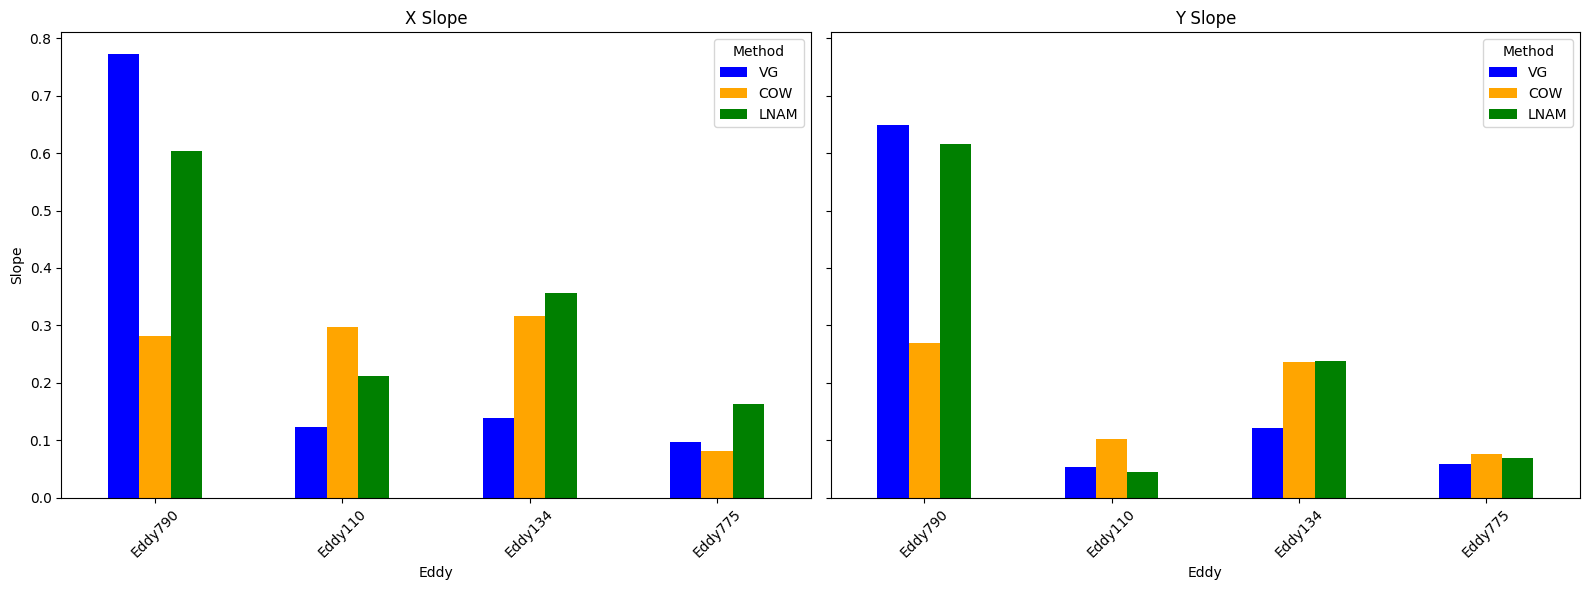

In [27]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot X_slope in the first subplot
abs(X_slope).plot(kind='bar', ax=axes[0], color=["blue", "orange", "green"])
axes[0].set_title("X Slope")
axes[0].set_xlabel("Eddy")
axes[0].set_ylabel("Slope")
axes[0].legend(title="Method")
axes[0].tick_params(axis='x', rotation=45)

# Plot Y_slope in the second subplot
abs(Y_slope).plot(kind='bar', ax=axes[1], color=["blue", "orange", "green"])
axes[1].set_title("Y Slope")
axes[1].set_xlabel("Eddy")
axes[1].legend(title="Method")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


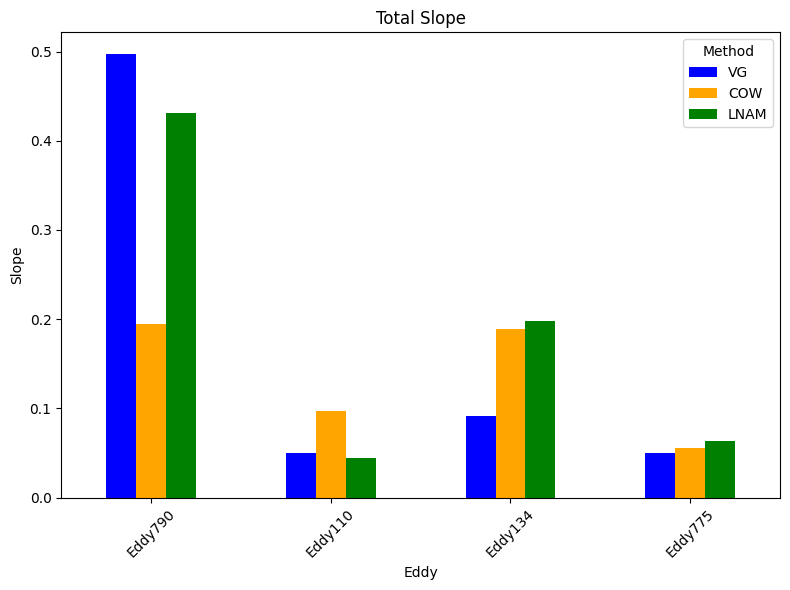

In [29]:
T_slope = abs((X_slope * Y_slope) / np.sqrt(X_slope**2 + Y_slope**2))

ax = T_slope.plot(kind='bar', figsize=(8, 6), color=["blue", "orange", "green"])
ax.set_title("Total Slope")
ax.set_xlabel("Eddy")
ax.set_ylabel("Slope")
plt.legend(title="Method")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Greater the slope, the smaller the tilt

In [226]:
T_slope

,VG,COW,LNAM
Eddy790,0.496659,0.194814,0.431181
Eddy110,0.049436,0.096664,0.044120
Eddy134,0.091371,0.189303,0.198216
Eddy775,0.049538,0.055351,0.063056


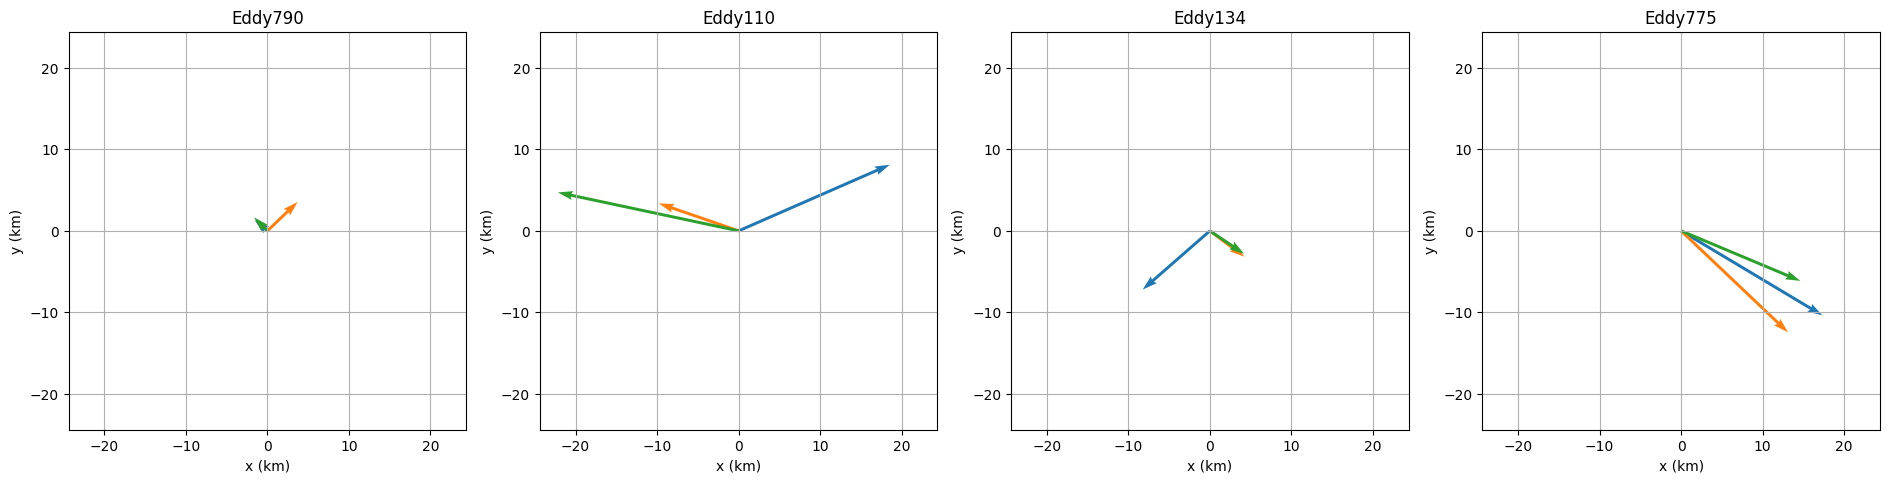

In [41]:
TiltDir = np.degrees(np.arctan2(X_slope, Y_slope)) % 360

fig, axs = plt.subplots(1, 4, figsize=(19, 9))  # 1x4 subplot grid

# Find the maximum extent of the vectors
max_extent = 0

for eddy in the_frontier_eddies:
    Tdiss = 1 / T_slope.loc[eddy]
    Tdirs = TiltDir.loc[eddy]
    
    for Tdis, Tdir in zip(Tdiss, Tdirs):
        Tdir_rad = np.radians(90 - Tdir)
        u = Tdis * np.cos(Tdir_rad)
        v = Tdis * np.sin(Tdir_rad)
        # Update max_extent with the maximum absolute values of u and v
        max_extent = max(max_extent, abs(u), abs(v))

# Set consistent limits based on the maximum extent
lims = max_extent * 1.1  # Add 10% margin

for idx, eddy in enumerate(the_frontier_eddies):
    Tdiss = 1 / T_slope.loc[eddy]
    Tdirs = TiltDir.loc[eddy]
    
    colors = plt.cm.tab10.colors
    i = 0
    for Tdis, Tdir in zip(Tdiss, Tdirs):
        Tdir_rad = np.radians(90 - Tdir)
        u = Tdis * np.cos(Tdir_rad)
        v = Tdis * np.sin(Tdir_rad)
        axs[idx].quiver(0, 0, u, v, angles='xy', scale_units='xy', scale=1, color=colors[i])
        i += 1
        
    axs[idx].set_xlim(-lims, lims)
    axs[idx].set_ylim(-lims, lims)
    axs[idx].set_aspect('equal', adjustable='box')
    axs[idx].grid()
    axs[idx].set_title(f"{eddy}")
    axs[idx].set_xlabel('x (km)')
    axs[idx].set_ylabel('y (km)')
plt.tight_layout()
plt.show()





## Birds Eye View

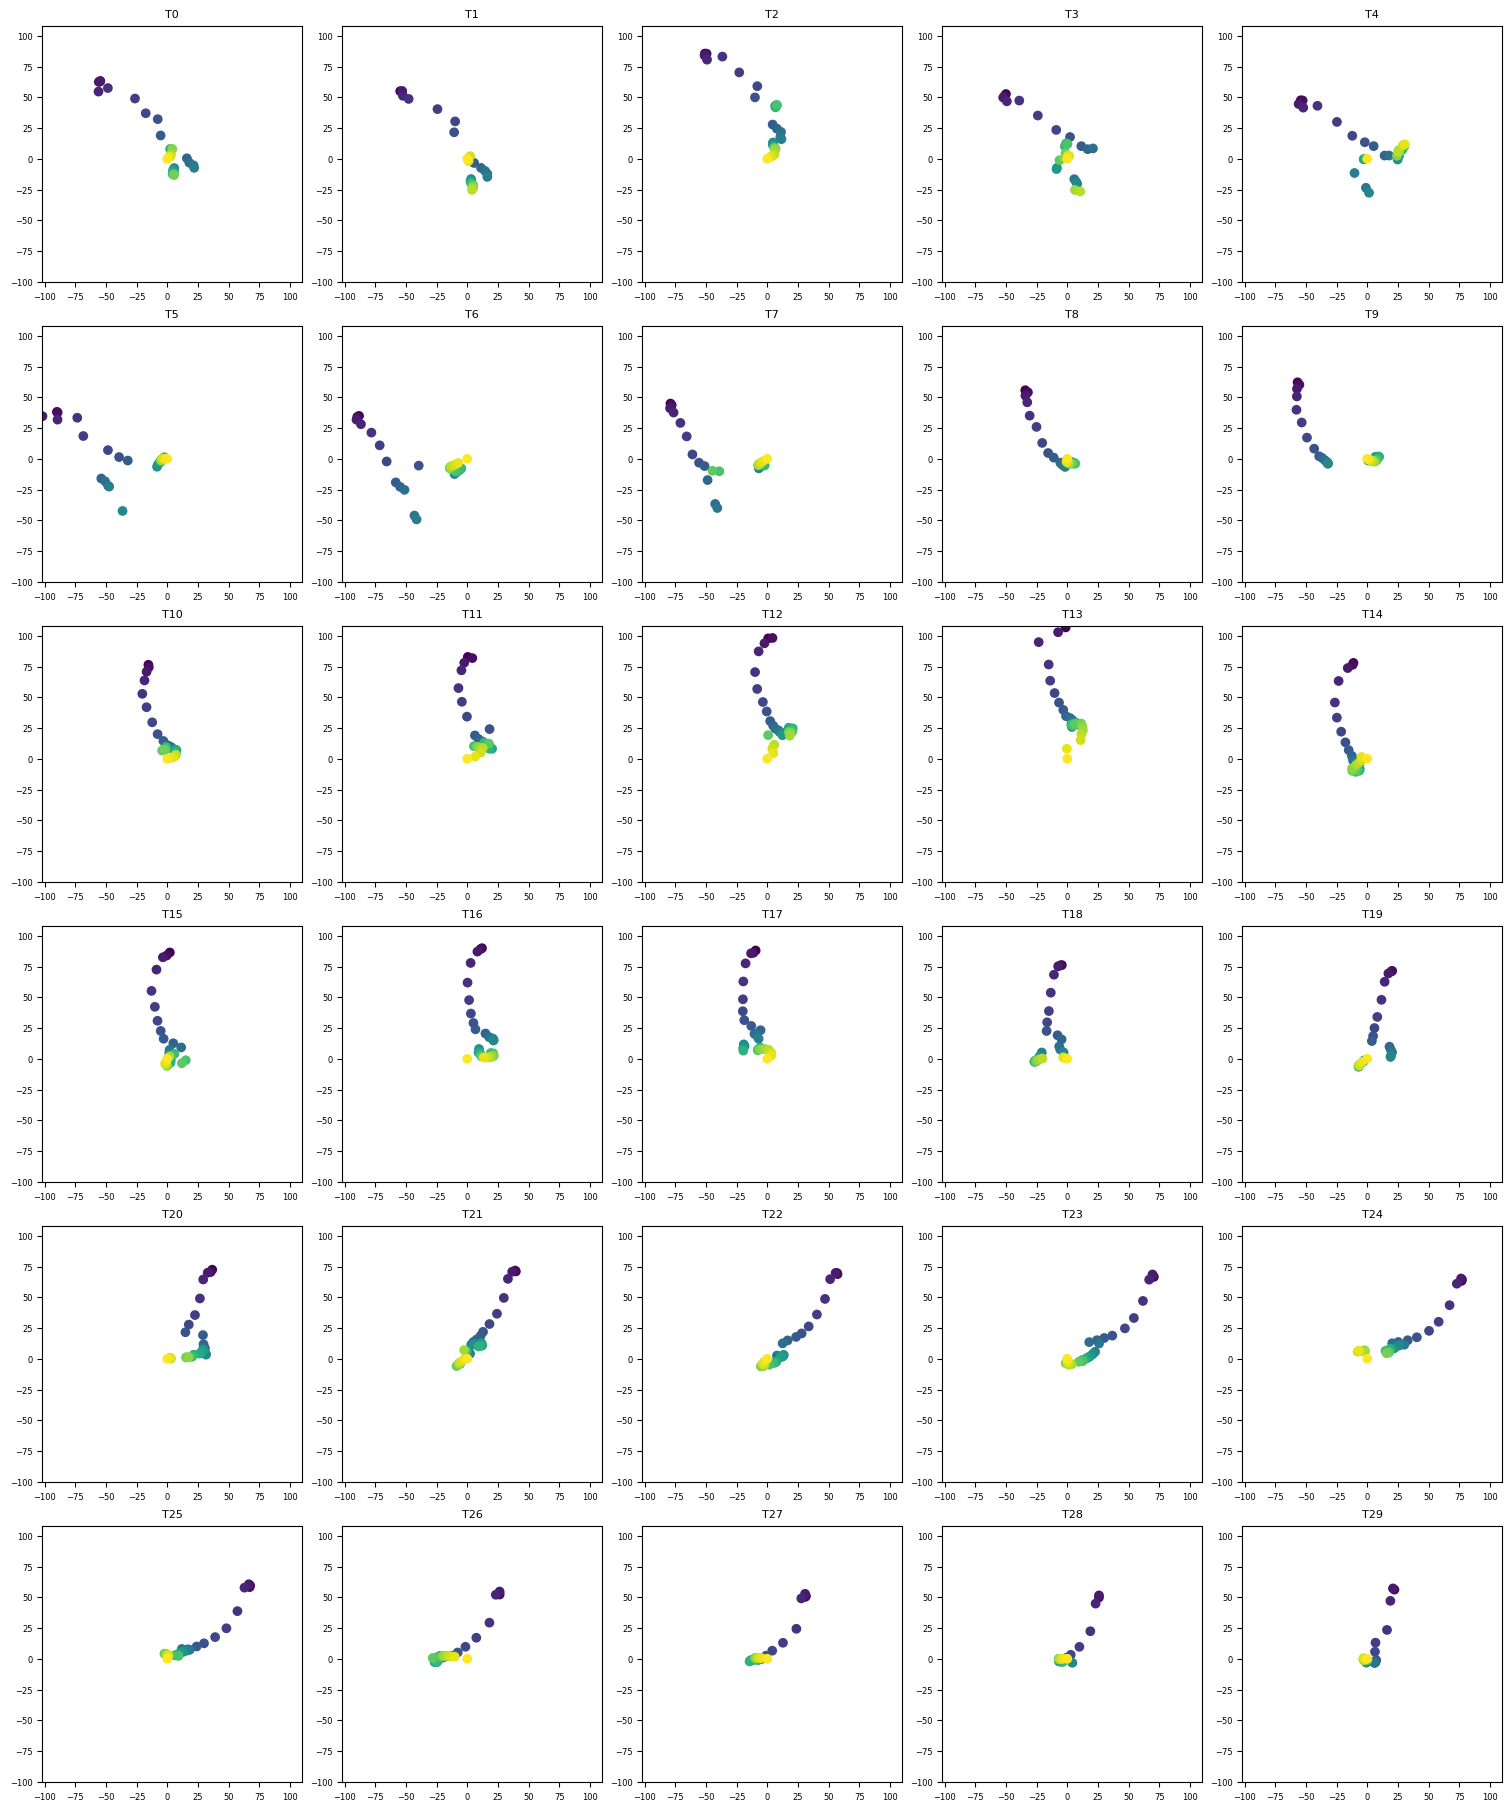

In [47]:
eddy = the_frontier_eddies[3]
fig, axes = plt.subplots(6, 5, figsize=(15, 18), constrained_layout=True)
method = 'VG'
x_df = pd.DataFrame()
y_df = pd.DataFrame()
for t in range(30):
    x_data = (frontier_sample_data[eddy][f'T{t}'][method]['x'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['x']) / 1000
    y_data = (frontier_sample_data[eddy][f'T{t}'][method]['y'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['y']) / 1000

    max_len = max(len(x_df), len(x_data))
    x_df = x_df.reindex(range(max_len)) 
    y_df = y_df.reindex(range(max_len))
    x_df[f'T{t}'] = pd.Series(x_data)
    y_df[f'T{t}'] = pd.Series(y_data)

Deltax = x_df.diff().cumsum()
Deltay = y_df.diff().cumsum()

x_min, x_max = x_df.min().min(), x_df.max().max()
y_min, y_max = y_df.min().min(), y_df.max().max()
lim_min, lim_max = min(x_min, y_min), max(x_max, y_max)  

cmap = plt.cm.viridis

for t in range(30):
    ax = axes[t // 5, t % 5]
    n_points = len(x_df[f'T{t}'])
    colors = cmap(np.linspace(0, 1, n_points))
    ax.scatter(x_df[f'T{t}'].iloc[::-1], y_df[f'T{t}'].iloc[::-1], color=colors)
    ax.set_title(f"T{t}", fontsize=8)
    ax.axis('equal')
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.tick_params(labelsize=6)
plt.show()

# light color at the top!

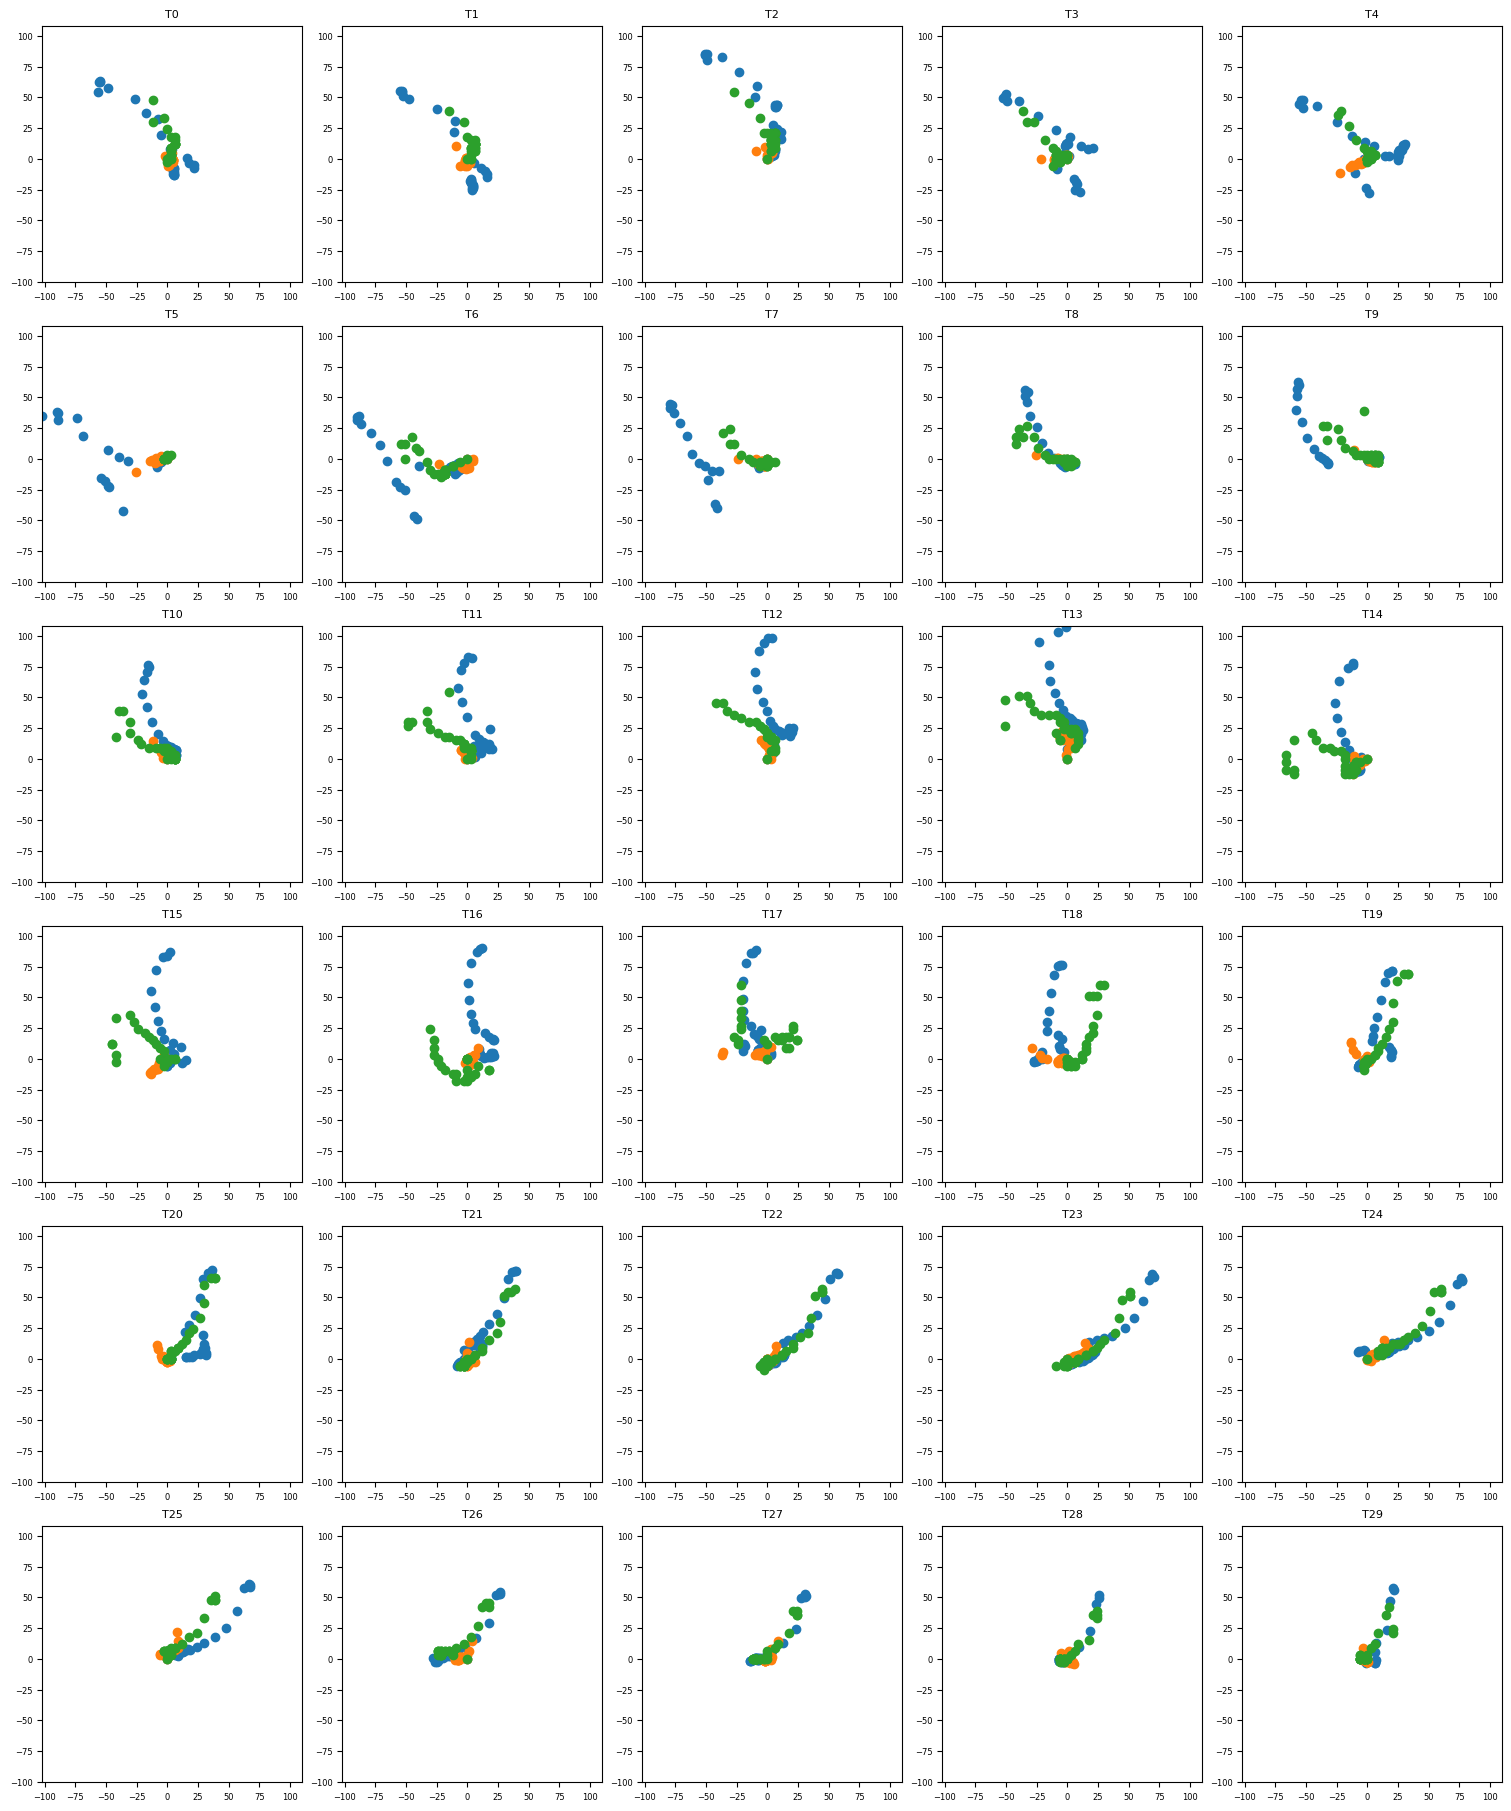

In [48]:
eddy = the_frontier_eddies[3]
fig, axes = plt.subplots(6, 5, figsize=(15, 18), constrained_layout=True)
xmin, xmax = 0, 0
ymin, ymax = 0, 0
for method in ['VG', 'COW', 'LNAM']:
    x_df = pd.DataFrame()
    y_df = pd.DataFrame()
    for t in range(30):
        x_data = (frontier_sample_data[eddy][f'T{t}'][method]['x'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['x']) / 1000
        y_data = (frontier_sample_data[eddy][f'T{t}'][method]['y'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['y']) / 1000
    
        max_len = max(len(x_df), len(x_data))
        x_df = x_df.reindex(range(max_len)) 
        y_df = y_df.reindex(range(max_len))
        x_df[f'T{t}'] = pd.Series(x_data)
        y_df[f'T{t}'] = pd.Series(y_data)    
        
    Deltax = x_df.diff().cumsum()
    Deltay = y_df.diff().cumsum()
    
    x_min, x_max = x_df.min().min(), x_df.max().max()
    y_min, y_max = y_df.min().min(), y_df.max().max()
    
    xmin, xmax = min(xmin, x_min), max(xmax, x_max)
    ymin, ymax = min(ymin, y_min), max(ymax, y_max)

    lim_min, lim_max = min(xmin, ymin), max(xmax, ymax)  
    
    cmap = plt.cm.viridis
    
    for t in range(30):
        ax = axes[t // 5, t % 5]
        n_points = len(x_df[f'T{t}'])
        colors = cmap(np.linspace(0, 1, n_points))
        ax.scatter(x_df[f'T{t}'].iloc[::-1], y_df[f'T{t}'].iloc[::-1])#, color=colors)
        ax.set_title(f"T{t}", fontsize=8)
        ax.axis('equal')
        ax.set_xlim(lim_min, lim_max)
        ax.set_ylim(lim_min, lim_max)
        ax.tick_params(labelsize=6)

plt.show()

## Depth

In [49]:
H_dic = {}
for eddy in the_frontier_eddies:
    H_df = pd.DataFrame()
    for method in ['VG', 'COW', 'LNAM']:
        Hs = []
        for t in range(30):
            Hs.append(z_r[150,150,len(frontier_sample_data[eddy]['T'+str(t)][method])-1])
        H_df[method] = Hs
    H_dic[eddy] = H_df

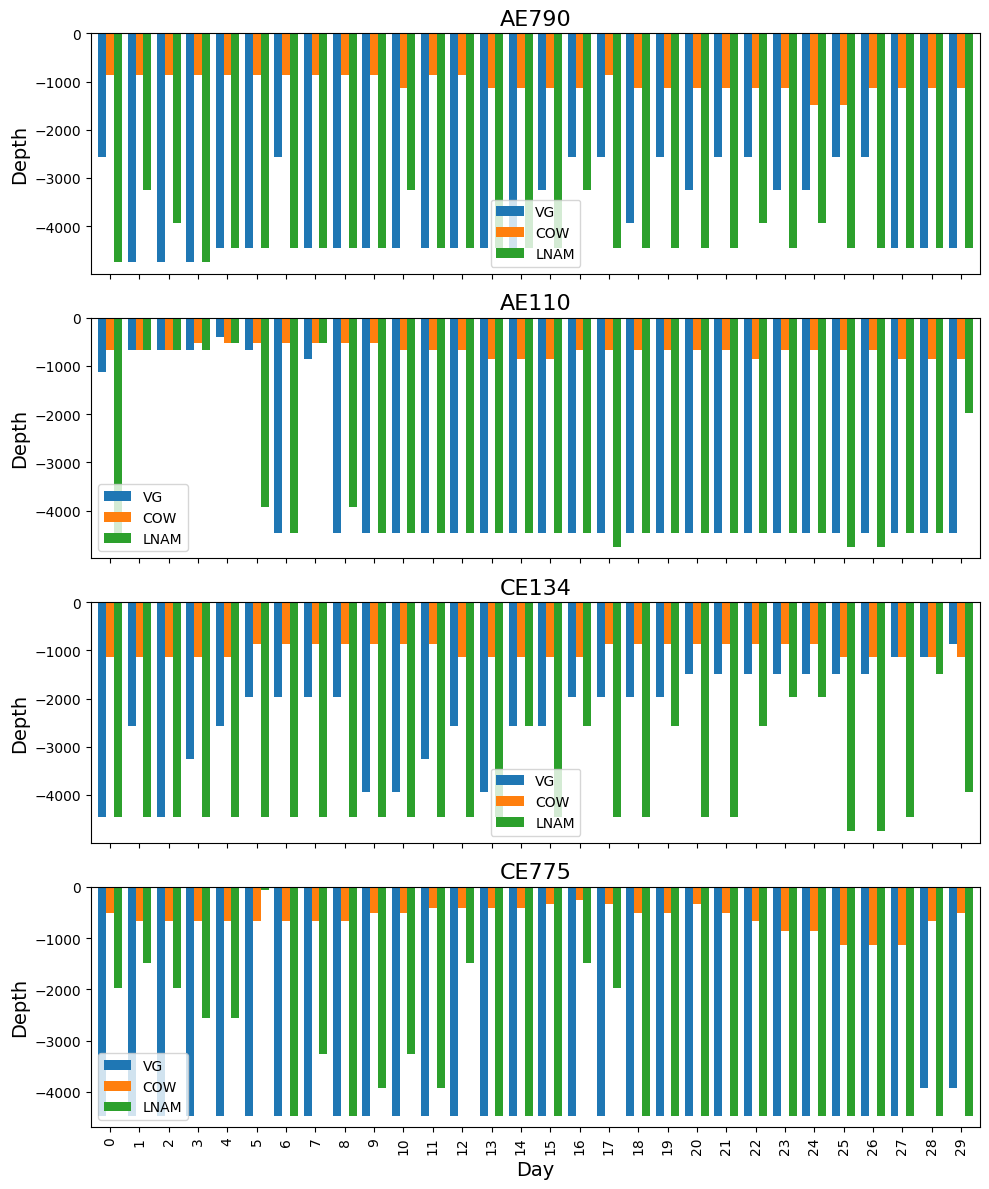

In [50]:
latex_names = ['AE790', 'AE110', 'CE134', 'CE775']
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 12), sharex=True)  
for i, eddy in enumerate(the_frontier_eddies):
    ax = axes[i] 
    (H_dic[eddy]).plot(kind='bar', ax=ax, width=0.8)  
    ax.set_title(latex_names[i], fontsize=16) 
    ax.set_ylabel('Depth', fontsize=14)  
    if i == 3:
        ax.set_xlabel('Day', fontsize=14)  

plt.tight_layout() 
plt.show()

## VG Vorticity

In [51]:
with open('/srv/scratch/z5297792/Sample/VG_vort.pkl', 'rb') as file:
    VG_vort = pickle.load(file)

for eddy in the_frontier_eddies:
    for t in range(30):
        VG_vort[eddy].iloc[d_dic[eddy]['T'+str(t)][0]:, t] = np.nan
    VG_vort[eddy] = VG_vort[eddy].dropna(how='all')
    

In [52]:
for eddy in the_frontier_eddies:
    last_non_nan = VG_vort[eddy].apply(lambda col: col[col.last_valid_index()])
    print(eddy +' '+str(last_non_nan.mean()))

Eddy790 6.438046328270836e-06
Eddy110 6.713377177226845e-06
Eddy134 -6.810483099598699e-06
Eddy775 -6.251704299951128e-06


Text(0.5, 1.0, 'Daily Average Vorticity')

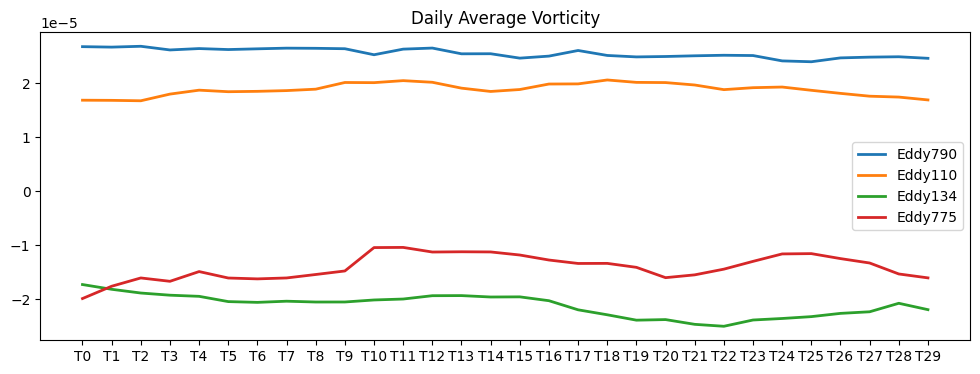

In [53]:
plt.figure(figsize=(12,4))
for eddy in the_frontier_eddies:
    plt.plot(VG_vort[eddy].mean(), label=eddy, linewidth=2)
plt.legend()
plt.title('Daily Average Vorticity')

Text(0.5, 1.0, 'Bottom Most Vorticity')

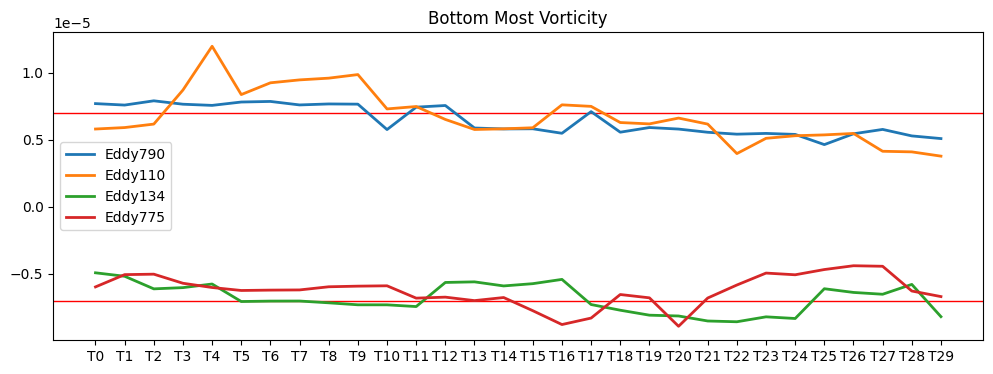

In [54]:
threshold = 7e-06
plt.figure(figsize=(12,4))
for eddy in the_frontier_eddies:
    df = VG_vort[eddy]
    last_valid_values = df.apply(lambda col: col.last_valid_index(), axis=0)
    last_non_nan_values = df.apply(lambda col: col.loc[col.last_valid_index()], axis=0)
    plt.plot(last_non_nan_values, label=eddy, linewidth=2)
plt.axhline(y=threshold, color='red', linewidth=1, zorder=-1)
plt.axhline(y=-threshold, color='red', linewidth=1, zorder=-1)
plt.legend()
plt.title('Bottom Most Vorticity')

In [55]:
method = 'VG'

TD_dic = {}
for eddy in the_frontier_eddies:
    x_df = pd.DataFrame()
    y_df = pd.DataFrame()
    for t in range(30):
        x_data = (frontier_sample_data[eddy][f'T{t}'][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['x']) / 1000
        y_data = (frontier_sample_data[eddy][f'T{t}'][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['y']) / 1000
    
        max_len = max(len(x_df), len(x_data))
        x_df = x_df.reindex(range(max_len)) 
        y_df = y_df.reindex(range(max_len))
        x_df[f'T{t}'] = pd.Series(x_data)
        y_df[f'T{t}'] = pd.Series(y_data)
        
    TD_dic[eddy] = np.hypot(x_df, y_df)

Text(0.5, 0, 'Tilt Distance')

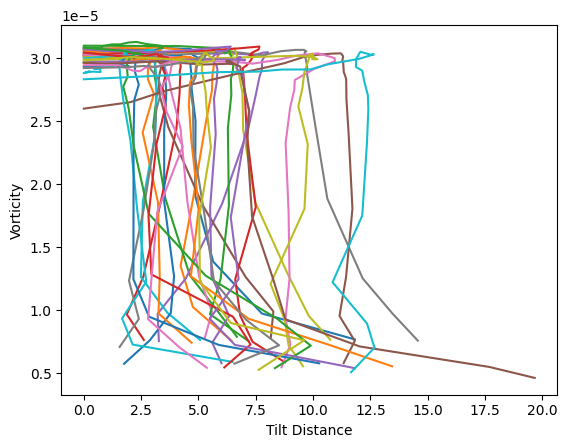

In [56]:
eddy = the_frontier_eddies[0]
for t in range(30):
    TD = TD_dic[eddy]['T'+str(t)]
    v = VG_vort[eddy]['T'+str(t)][:len(TD)]
    plt.plot(TD, v)
plt.ylabel('Vorticity')
plt.xlabel('Tilt Distance')

Text(0.5, 0, 'Tilt Distance')

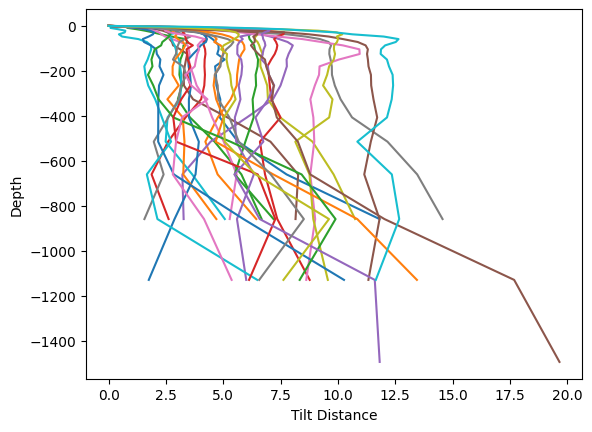

In [57]:
eddy = the_frontier_eddies[0]
for t in range(30):
    TD = TD_dic[eddy]['T'+str(t)]
    z = z_r[150, 150, :len(TD)]
    plt.plot(TD, z)
plt.ylabel('Depth')
plt.xlabel('Tilt Distance')

Text(0.5, 0, 'Vorticity')

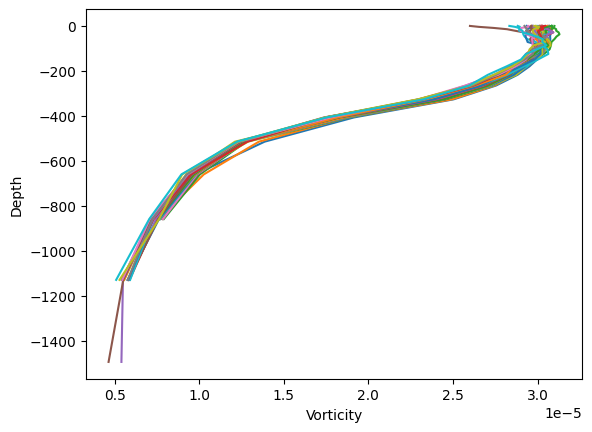

In [58]:
eddy = the_frontier_eddies[0]
for t in range(30):
    TD = TD_dic[eddy]['T'+str(t)]
    v = VG_vort[eddy]['T'+str(t)][:len(TD)]
    z = z_r[150, 150, :len(TD)]
    plt.plot(v, z)
plt.ylabel('Depth')
plt.xlabel('Vorticity')

### Depth with vort threshold

In [59]:
threshold = 7e-06

vort_depth_dic = {}
for eddy in the_frontier_eddies:
    threshold_indices = {}
    for column in VG_vort[eddy].columns:
        if VG_vort[eddy].iloc[0][column] < 0:
            thresh_adjusted = -threshold
            index = VG_vort[eddy][VG_vort[eddy][column] >= thresh_adjusted].index.min()
        else:
            thresh_adjusted = threshold
            index = VG_vort[eddy][VG_vort[eddy][column] <= thresh_adjusted].index.min()
        if np.isnan(index):
            index = len(VG_vort[eddy][column])
        threshold_indices[column] = index
    vort_depth_dic[eddy] = threshold_indices

H_vort_thresh_dic = {}
for eddy in the_frontier_eddies:
    H_df = pd.DataFrame()
    for method in ['VG', 'COW', 'LNAM']:
        Hs = []
        for t in range(30):
            if method == 'VG':
                Hs.append(z_r[150,150,vort_depth_dic[eddy]['T'+str(t)]])
            else:
                Hs.append(z_r[150,150,len(frontier_sample_data[eddy]['T'+str(t)][method])-1])
        H_df[method] = Hs
    H_vort_thresh_dic[eddy] = H_df

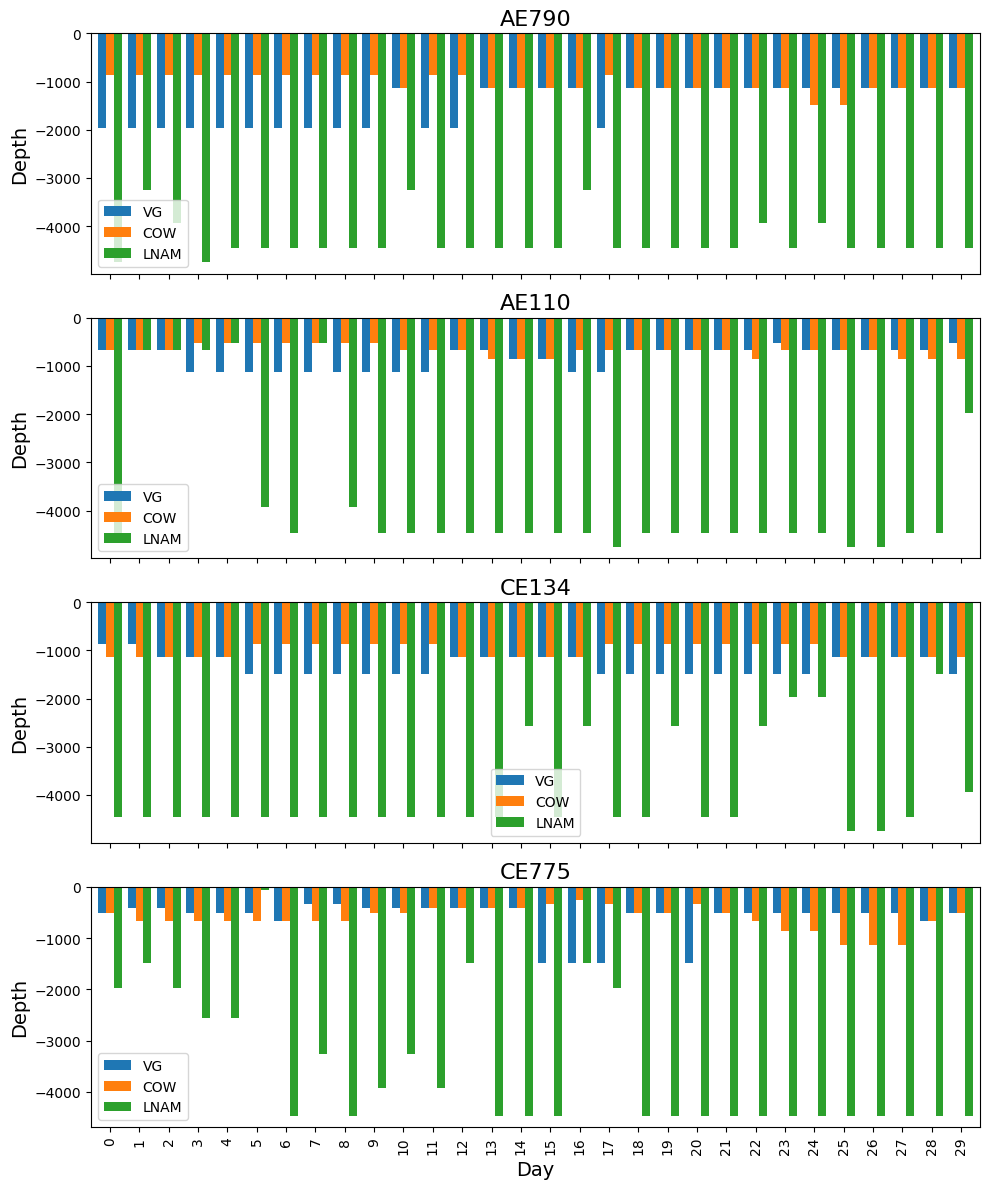

In [60]:
latex_names = ['AE790', 'AE110', 'CE134', 'CE775']
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 12), sharex=True)  
for i, eddy in enumerate(the_frontier_eddies):
    ax = axes[i] 
    (H_vort_thresh_dic[eddy]).plot(kind='bar', ax=ax, width=0.8)  
    ax.set_title(latex_names[i], fontsize=16) 
    ax.set_ylabel('Depth', fontsize=14)  
    if i == 3:
        ax.set_xlabel('Day', fontsize=14)  

plt.tight_layout() 
plt.show()


## Eddy Days

In [69]:
# Drop Li 2022 measurment of tilt
for eddy in the_frontier_eddies:
    for t in range(30):
        for method in methods:
            frontier_sample_data[eddy]['T'+str(t)][method] = frontier_sample_data[eddy]['T'+str(t)][method].drop(columns=['TD'])

In [74]:
TD_dic = {}
for method in methods:
    TD_eddy_dic = {}
    for eddy in the_frontier_eddies:
        x_df = pd.DataFrame()
        y_df = pd.DataFrame()
        for t in range(30):
            x_data = (frontier_sample_data[eddy][f'T{t}'][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['x'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['x']) / 1000
            y_data = (frontier_sample_data[eddy][f'T{t}'][method].iloc[:d_dic[eddy]['T'+str(t)][0]]['y'] - frontier_sample_data[eddy][f'T{t}'][method].iloc[0]['y']) / 1000
        
            max_len = max(len(x_df), len(x_data))
            x_df = x_df.reindex(range(max_len)) 
            y_df = y_df.reindex(range(max_len))
            x_df[f'T{t}'] = pd.Series(x_data)
            y_df[f'T{t}'] = pd.Series(y_data)
            
        TD_eddy_dic[eddy] = np.hypot(x_df, y_df)
    TD_dic[method] = TD_eddy_dic

30.237563209001053
240.8709039847453


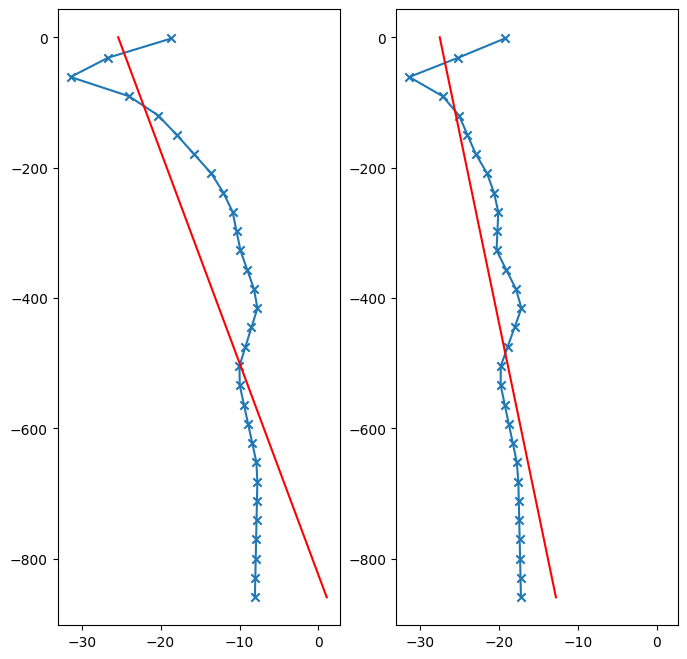

In [219]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))

eddy = the_frontier_eddies[2]
method = 'VG'
t = 29

COW_d = d_dic[eddy]['T'+str(t)][0]
x, y, z = frontier_sample_data[eddy]['T'+str(t)][method].iloc[:COW_d]['x']/1000, frontier_sample_data[eddy]['T'+str(t)][method].iloc[:COW_d]['y']/1000, list(frontier_sample_data[eddy]['T'+str(t)][method].iloc[:COW_d]['Depth'])

# axs[0].plot(x, z)
# axs[1].plot(y, z)

# Interpolation and polynomial fitting process
x_original = x
y_original = y
z_original = z
num = 30 
z_new = np.flip(np.linspace(np.min(z), np.max(z), num=num))
interpolate_func = interp1d(z_original, x_original, kind='linear', fill_value="extrapolate")
x_new = interpolate_func(z_new)
interpolate_func = interp1d(z_original, y_original, kind='linear', fill_value="extrapolate")
y_new = interpolate_func(z_new)
x, y, z = x_new, y_new, z_new

axs[0].plot(x, z)
axs[0].scatter(x, z, marker='x')
axs[1].plot(y, z)
axs[1].scatter(y, z, marker='x')

z_top = 0
z_btm = z[-1] 
coefficients_x = np.polyfit(x, z, 1)
slope_x, intercept_x = coefficients_x
slopes_x.append(slope_x)
coefficients_y = np.polyfit(y, z, 1)
slope_y, intercept_y = coefficients_y
slopes_y.append(slope_y)
x_btm = (z_btm - intercept_x) / slope_x
x_top = (z_top - intercept_x) / slope_x
y_btm = (z_btm - intercept_y) / slope_y
y_top = (z_top - intercept_y) / slope_y
axs[0].plot([x_btm, x_top], [z_btm, z_top], color='red')
axs[1].plot([y_btm, y_top], [z_btm, z_top], color='red')

xlim0 = axs[0].get_xlim()
xlim1 = axs[1].get_xlim()

axs[0].set_xlim([min(xlim0[0], xlim1[0]), max(xlim0[1], xlim1[1])])
axs[1].set_xlim([min(xlim0[0], xlim1[0]), max(xlim0[1], xlim1[1])])

TDis = np.hypot(x_btm-x_top, y_btm-y_top)
print(TDis)
TDir = (90 - np.degrees(np.arctan2(slope_x, slope_y)) ) % 360
print(TDir)

In [140]:
clim_df = {}
for eddy in the_frontier_eddies:
    m_df = {}
    for method in methods:
        t_df = pd.DataFrame()
        for t in range(30):
        
            COW_d = d_dic[eddy]['T'+str(t)][0]
            x, y, z = frontier_sample_data[eddy]['T'+str(t)][method].iloc[:COW_d]['x']/1000, frontier_sample_data[eddy]['T'+str(t)][method].iloc[:COW_d]['y']/1000, list(frontier_sample_data[eddy]['T'+str(t)][method].iloc[:COW_d]['Depth'])
            
            # Interpolation and polynomial fitting process
            x_original = x
            y_original = y
            z_original = z
            num = 30 
            z_new = np.flip(np.linspace(np.min(z), np.max(z), num=num))
            interpolate_func = interp1d(z_original, x_original, kind='linear', fill_value="extrapolate")
            x_new = interpolate_func(z_new)
            interpolate_func = interp1d(z_original, y_original, kind='linear', fill_value="extrapolate")
            y_new = interpolate_func(z_new)
            x, y, z = x_new, y_new, z_new
            
            z_top = 0
            z_btm = z[-1] 
            coefficients_x = np.polyfit(x, z, 1)
            slope_x, intercept_x = coefficients_x
            slopes_x.append(slope_x)
            coefficients_y = np.polyfit(y, z, 1)
            slope_y, intercept_y = coefficients_y
            slopes_y.append(slope_y)
            x_btm = (z_btm - intercept_x) / slope_x
            x_top = (z_top - intercept_x) / slope_x
            y_btm = (z_btm - intercept_y) / slope_y
            y_top = (z_top - intercept_y) / slope_y
            
            TDis = np.hypot(x_btm-x_top, y_btm-y_top)
        
            TDir = (90 - np.degrees(np.arctan2(slope_x, slope_y)) ) % 360
        
            t_df['T'+str(t)] = {'TDis': TDis, 'TDir': TDir}
            
        m_df[method] = t_df
        
    clim_df[eddy] = m_df

/scratch/pbs.6043990.kman.restech.unsw.edu.au/ipykernel_3716536/135940306.py:28: RankWarning: Polyfit may be poorly conditioned
  coefficients_y = np.polyfit(y, z, 1)
/scratch/pbs.6043990.kman.restech.unsw.edu.au/ipykernel_3716536/135940306.py:25: RankWarning: Polyfit may be poorly conditioned
  coefficients_x = np.polyfit(x, z, 1)
/scratch/pbs.6043990.kman.restech.unsw.edu.au/ipykernel_3716536/135940306.py:28: RankWarning: Polyfit may be poorly conditioned
  coefficients_y = np.polyfit(y, z, 1)


In [216]:
def find_starting_point(lat2_list, lon2_list, distance_list, bearing_list, radius=6371):
    # Ensure all inputs are lists of the same length
    n = len(lat2_list)
    if not all(len(lst) == n for lst in [lon2_list, distance_list, bearing_list]):
        raise ValueError("All input lists must have the same length")

    # Initialize a list to hold the results
    results = []

    # Loop over the inputs
    for lat2, lon2, distance, bearing in zip(lat2_list, lon2_list, distance_list, bearing_list):
        # Convert input to radians
        lat2 = math.radians(lat2)
        lon2 = math.radians(lon2)
        bearing = math.radians(bearing)

        # Calculate starting latitude
        lat1 = math.asin(math.sin(lat2) * math.cos(distance / radius) +
                         math.cos(lat2) * math.sin(distance / radius) * math.cos(bearing))

        # Calculate starting longitude
        lon1 = lon2 - math.atan2(math.sin(bearing) * math.sin(distance / radius),
                                 math.cos(distance / radius) - math.sin(lat2) * math.sin(lat1))

        # Convert back to degrees
        lat1 = math.degrees(lat1)
        lon1 = math.degrees(lon1)

        # Append the result for this set of inputs
        results.append((lat1, lon1))

    return results

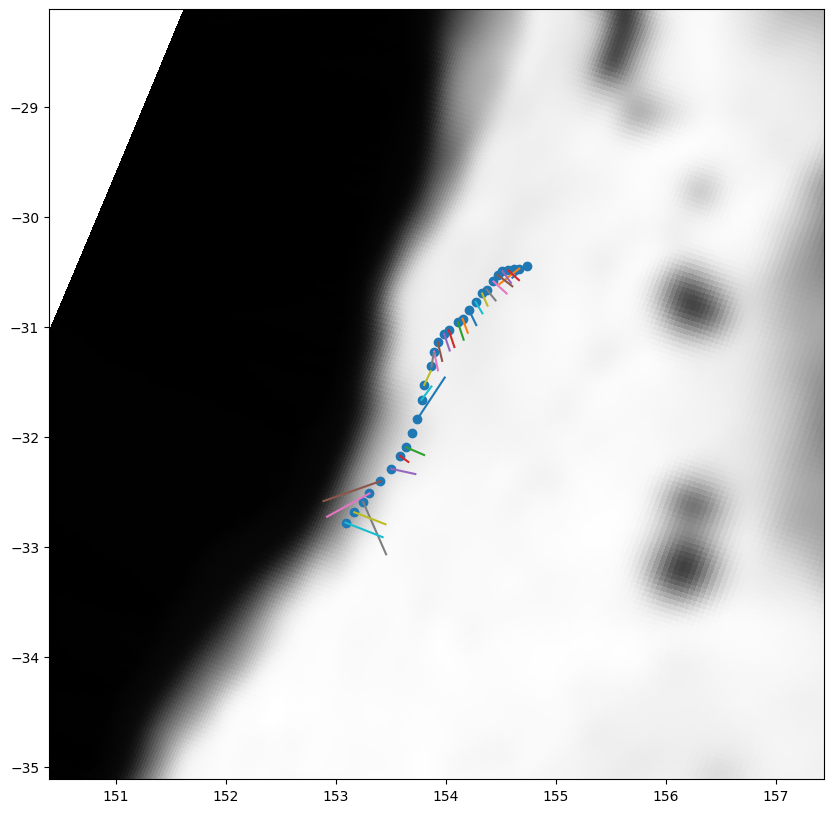

In [214]:
for eddy in the_frontier_eddies:
    method = 'VG'
    
    eddy_data = eddies[eddy]
    middle_index = eddy_data.shape[0] // 2
    eddy_data = eddy_data.iloc[middle_index - 15: middle_index + 15]
    
    Tdis = clim_df[eddy][method].loc['TDis']
    Tdis = Tdis.copy()
    Tdis.loc[Tdis > 100] = np.nan
    Tdir = clim_df[eddy][method].loc['TDir']
    
    results= find_starting_point(eddy_data['Lat'], eddy_data['Lon'], Tdis, Tdir, radius=6371)
    lat, lon = zip(*results)
    
    plt.figure(figsize=(10, 10))
    plt.pcolor(lon_rho, lat_rho, h, cmap='grey')
    plt.scatter(eddy_data['Lon'], eddy_data['Lat'])
    x_min = min(eddy_data['Lon'].min(), np.min(lon))
    x_max = max(eddy_data['Lon'].max(), np.max(lon))
    y_min = min(eddy_data['Lat'].min(), np.min(lat))
    y_max = max(eddy_data['Lat'].max(), np.max(lat))
    padding_x = 1 * (x_max - x_min)
    padding_y = 1 * (y_max - y_min)
    x_lim = (x_min - padding_x, x_max + padding_x)
    y_lim = (y_min - padding_y, y_max + padding_y)
    
    for lon1, lat1, lon2, lat2 in zip(lon, lat, eddy_data['Lon'], eddy_data['Lat']):
        plt.plot([lon1, lon2], [lat1, lat2])
    
plt.axis('equal')
plt.xlim(x_lim)
plt.ylim(y_lim)

plt.show()



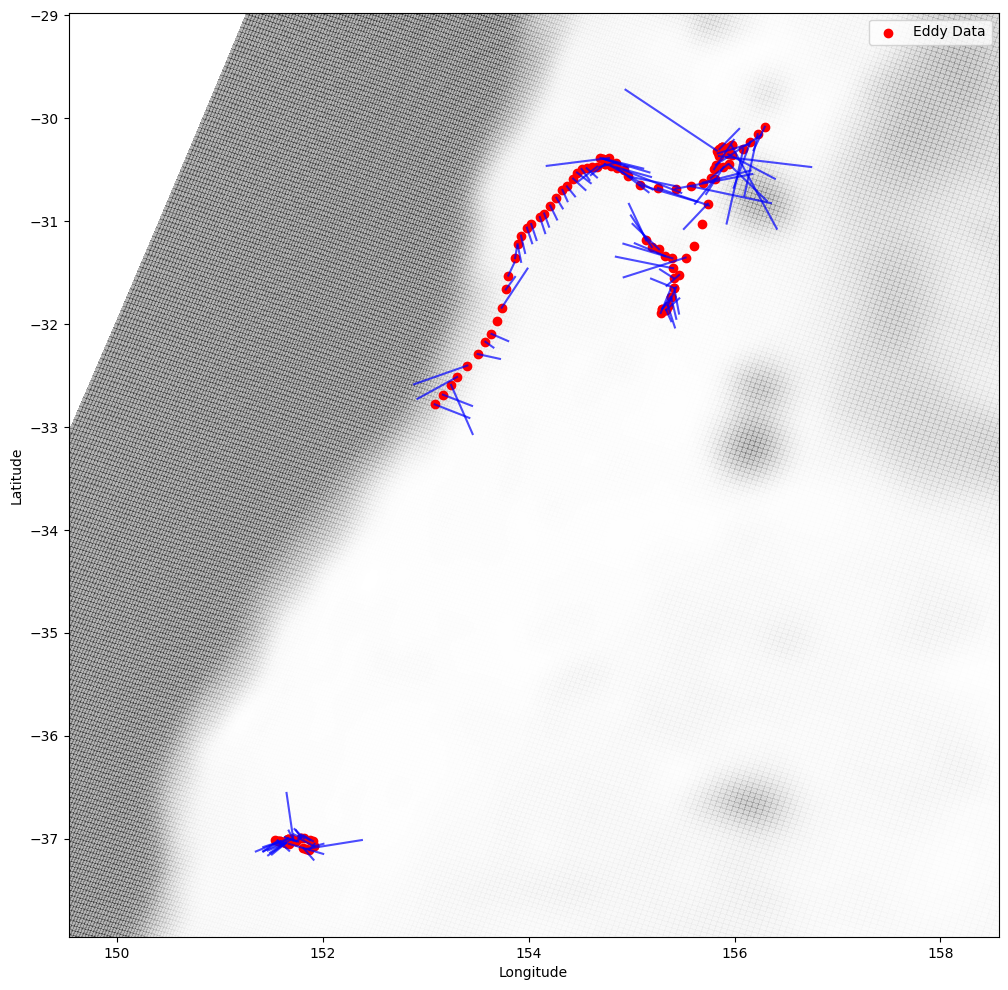

In [224]:
# Initialize lists to collect all eddy data
all_lon = []
all_lat = []
all_lines = []
all_eddy_lons = []
all_eddy_lats = []

# Loop through each eddy and collect data
for eddy in the_frontier_eddies:
    method = 'VG'
    
    # Extract and preprocess eddy data
    eddy_data = eddies[eddy]
    middle_index = eddy_data.shape[0] // 2
    eddy_data = eddy_data.iloc[middle_index - 15: middle_index + 15]
    
    # Process Tdis and Tdir
    Tdis = clim_df[eddy][method].loc['TDis'].copy()
    Tdis[Tdis > 100] = np.nan
    Tdir = clim_df[eddy][method].loc['TDir']
    
    # Calculate starting points
    results = find_starting_point(eddy_data['Lat'], eddy_data['Lon'], Tdis, Tdir, radius=6371)
    lat, lon = zip(*results)
    
    # Collect data for plotting
    all_lon.extend(lon)
    all_lat.extend(lat)
    all_eddy_lons.extend(eddy_data['Lon'])
    all_eddy_lats.extend(eddy_data['Lat'])
    all_lines.extend(zip(lon, lat, eddy_data['Lon'], eddy_data['Lat']))

# Plot all collected data
plt.figure(figsize=(12, 12))
plt.pcolor(lon_rho, lat_rho, h, cmap='grey', alpha=0.3)  # Semi-transparent background

# Scatter eddy data
plt.scatter(all_eddy_lons, all_eddy_lats, color='red', label='Eddy Data')

# Plot lines
for lon1, lat1, lon2, lat2 in all_lines:
    plt.plot([lon1, lon2], [lat1, lat2], color='blue', alpha=0.7)

# Adjust plot limits
x_min = min(all_eddy_lons + all_lon)
x_max = max(all_eddy_lons + all_lon)
y_min = min(all_eddy_lats + all_lat)
y_max = max(all_eddy_lats + all_lat)

padding_x = 0.1 * (x_max - x_min)
padding_y = 0.1 * (y_max - y_min)

plt.axis('equal')
plt.xlim(x_min - padding_x, x_max + padding_x)
plt.ylim(y_min - padding_y, y_max + padding_y)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


